# **Integrantes**
* Jose Luis Barba Farro
* Luis Angel Moreno Esquivel

# **Hardware utilizado**
Nombre del dispositivo	DESKTOP-N7HHBS8

Procesador	AMD Ryzen 7 5700G with Radeon Graphics            3.80 GHz

RAM instalada	16.0 GB (15.3 GB usable)



Tipo de sistema	Sistema operativo de 64 bits, procesador basado en x64

In [378]:
import os
import numpy as np
import cv2 as cv 
import io as io
import matplotlib.pyplot as plt
import matplotlib.image as mpi
from PIL import Image
from codecs import utf_16_be_decode
from skimage.filters import threshold_isodata, threshold_otsu, threshold_sauvola, threshold_niblack
from skimage import img_as_ubyte
from scipy.ndimage import grey_erosion, grey_dilation, grey_closing, grey_opening, binary_erosion,binary_dilation, white_tophat, black_tophat, binary_opening, binary_closing
import doxapy
from pythreshold.global_th.entropy.kapur import kapur_threshold
from skimage.morphology import disk, ball, diamond,square, star
from skimage.filters import median,gaussian,roberts,prewitt,laplace
from skimage.measure import euler_number, label, find_contours, regionprops, regionprops_table
import scipy.signal
import scipy.ndimage
from skimage.filters.rank import equalize
%matplotlib inline

In [384]:
def readGrayscaleimage(path): 
    #read image GBR or grayScale 
    image = cv.imread(path)
    
    arrayImage = np.asarray(image)
    if arrayImage.ndim == 3:
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)

    return image

In [385]:
class Convolution:
    @classmethod
    def box_blur_kernel(cls, size):#media
        mean = np.ones(shape=(size,size)).astype(np.float32) / (size**2)
        return mean
    
    @classmethod
    def identity_kernel(cls, size): #mediana
        mediana = np.ones(shape=(size,size)).astype(np.uint8)
        return mediana
    
    @classmethod
    def Gaussian_blur(cls, size, std=1):
        if size == 3:
            kernel = (1/16)*np.array(
              [[1, 2, 1],
              [2, 4, 2],
              [1, 2, 1],])
            return kernel
        if size == 5:
            kernel = (1/256)*np.array(
              [[1, 4, 6, 4, 1],
              [4, 16, 24, 16, 4],
              [6, 24, 36, 24, 6],
              [4, 16, 24, 16, 4],
              [1, 4, 6, 4, 1],])
            return kernel
      
        kernel = np.zeros(shape=(size, size), dtype=np.float32)
        double_var = 2 * (std**2)
        pi = 3.1416
        m = size//2
        for i in range(size):
            for j in range(size):
                r = (i-m)**2 + (j-m)**2
                kernel[i,j] = np.exp(-r/double_var) / (pi*double_var) 
        z = np.sum(kernel)
        return kernel/z
    
    @classmethod
    def emboss_kernel(cls, size): #realce
        middle = size//2
        kernel = -1 * np.ones(shape=(size, size),dtype=np.uint8)
        z = (size*size) - 1
        kernel = kernel / z
        kernel[middle, middle] = 1
        return kernel
        
    @classmethod
    def sharpen_kernel(cls, size):
        #https://www.globalsino.com/EM/page1371.html
        middle = size//2
        kernel = -1 * np.ones(shape=(size, size),dtype=np.int16)
        kernel[middle, middle] = (size*size)
        return kernel
    @classmethod
    def high_pass_kernel(cls, size):
        #https://www.irya.unam.mx/computo/sites/manuales/IDL/Content/GuideMe/ImageProcessing/HighPassFilter.html  
        #http://what-when-how.com/embedded-image-processing-on-the-tms320c6000-dsp/image-enhancement-via-spatial-filtering-image-processing-part-1/   
        middle = size//2
        kernel = -1 * np.ones(shape=(size, size),dtype=np.uint8)
        z = (size*size)
        kernel = kernel / z
        kernel[middle, middle] = ((size*size)-1)/ z
        return kernel 
    @classmethod
    def mean_k(cls, size,k=1):
        middle = size // 2
        mean = np.ones(shape=(size,size)).astype(np.float32) / (size**2 + k)
        mean[middle,middle] = k
        return mean
    
    @classmethod
    def motion_blur(cls,size, angle):
        #from grades to radians
        angle_rad = np.radians(angle)
        center = size//2
        kernel = np.zeros(shape=(size, size))
        #the slope of the blur line
        slope = np.tan(angle_rad)
        
        for i in range(size):
            offset = i - center
            kernel[i, int(round(center + offset * slope))] = 1 / size
            
        return kernel
    
    @classmethod
    def kirsch_edge_detector(cls, angle):
        if angle == 0:
            return np.array(
                [[ 5,  5,  5],
                 [-3,  0, -3],
                 [-3, -3, -3]]
            )
        if angle == 45:
            return np.array(
                [[5,  5,  -3],
                 [5,  0,  -3],
                 [-3, -3, -3]]
            )
        if angle == 90:
            return np.array(
                [[5, -3,  -3],
                 [5,  0,  -3],
                 [5, -3,  -3]]
            )
        if angle == 135:
            return np.array(
                [[-3, -3, -3],
                 [5,  0,  -3],
                 [5,  5,  -3]])

In [386]:
class filter_2D(Convolution):
    @classmethod
    def gaussian_filter(cls, input_arr, sigma, order=0, mode='reflect', cval=0.0, truncate=4.0,radius=None):
        derivate = scipy.ndimage.gaussian_filter(
            input_arr, 
            sigma=sigma, 
            order=order,
            mode=mode,
            radius=radius,
            cval=cval,
            truncate=truncate,
        )
        return derivate
    
    @classmethod
    def median_filter(cls, input_arr, size=None, footprint=None, output=None, mode='reflect', cval=0.0, origin=0):
        derivate = scipy.ndimage.median_filter(
            input_arr, 
            size=size, 
            footprint=footprint, 
            output=output, 
            mode=mode, 
            cval=cval, 
            origin=origin
        )
        return derivate
    
    @classmethod
    def conv2d(cls, input_arr, kernel, output=None, mode='reflect', cval=0.0, origin=0):
        derivate = scipy.ndimage.convolve(
            input_arr, 
            kernel, 
            output=output, 
            mode=mode, 
            cval=cval, 
            origin=origin
        )
        return derivate
    @classmethod
    def motion_blur_filter(cls,input_arr, size=21, angle=45,output=None, mode='reflect', cval=0.0, origin=0):
        kernel = cls.motion_blur(size=size, angle=angle)
        derivate = cls.conv2d(
            input_arr, 
            kernel, 
            output=output, 
            mode=mode, 
            cval=cval, 
            origin=origin
        )
        return derivate
    
    @classmethod
    def emboss_filter(cls,input_arr, size=21, output=None, mode='reflect', cval=0.0, origin=0):
        kernel = cls.emboss_kernel(size=size)
        derivate = cls.conv2d(
            input_arr, 
            kernel, 
            output=output, 
            mode=mode, 
            cval=cval, 
            origin=origin
        )
        return derivate
    @classmethod
    def sharpen_filter(cls,input_arr, size=21, output=None, mode='reflect', cval=0.0, origin=0):
        kernel = cls.sharpen_kernel(size=size)
        derivate = cls.conv2d(
            input_arr, 
            kernel, 
            output=output, 
            mode=mode, 
            cval=cval, 
            origin=origin
        )
        return derivate
    
    
    @classmethod
    def mean_k_filter(cls,input_arr, size=21, k=1, output=None, mode='reflect', cval=0.0, origin=0):
        kernel = cls.mean_k(size=size,k=k)
        derivate = cls.conv2d(
            input_arr, 
            kernel, 
            output=output, 
            mode=mode, 
            cval=cval, 
            origin=origin
        )
        return derivate
    @classmethod
    def maximum_filter(cls,input_arr, size=20, footprint=None, output=None, mode='reflect', cval=0.0, origin=0):
        derivate = scipy.ndimage.maximum_filter(
            input_arr, 
            size=size, 
            footprint=footprint, 
            output=output, 
            mode=mode, 
            cval=cval, 
            origin=origin
        )
        return derivate
    
    @classmethod
    def minimum_filter(cls,input_arr, size=20, footprint=None, output=None, mode='reflect', cval=0.0, origin=0):
        derivate = scipy.ndimage.minimum_filter(
            input_arr, 
            size=size, 
            footprint=footprint, 
            output=output, 
            mode=mode, 
            cval=cval, 
            origin=origin
        )
        return derivate
    
    @classmethod
    def rank_filter(cls,input_arr, rank=42, size=5, footprint=None, output=None, mode='reflect', cval=0.0, origin=0):
        derivate = scipy.ndimage.rank_filter(
            input_arr, 
            rank=rank, 
            size=size, 
            footprint=footprint, 
            output=output, 
            mode=mode, 
            cval=cval, 
            origin=origin
        )
        return derivate
    @classmethod
    def kirsh_edge_detector_filter(cls, input_arr, angle=45,output=None, mode='reflect', cval=0.0, origin=0):
        kernel = cls.kirsch_edge_detector(angle=angle)
        derivate = cls.conv2d(
            input_arr, 
            kernel, 
            output=output, 
            mode=mode, 
            cval=cval, 
            origin=origin
        )
        return derivate

In [387]:
class Equalization:
    def __init__(self):
        pass
    @classmethod
    def contrast_stretching(cls, image):
        min_value = np.min(image)
        max_value = np.max(image)
        if min_value < 100:
            desired_min = 0
            desired_max = 255
            slope = (desired_max - desired_min) / (max_value - min_value)
            intercept = desired_min - slope * min_value
            stretched_image = slope * image + intercept
            stretched_image = np.round(stretched_image).astype(np.uint8)
            return stretched_image
        else:
            return image
        
    @classmethod
    def histogram_equalization(cls, img):
        derv = cv.equalizeHist(img)
        return derv
             
    @classmethod
    def local_equalization(cls, img, mask_size=5):
        derv = equalize(img, disk(mask_size))
        return derv
    @classmethod         
    def call(cls,type_equalization, img, mask_size=5):
        if type_equalization == 'stretching':
            return Equalization.contrast_stretching(img)
        elif type_equalization == 'histogram':
            return Equalization.histogram_equalization(img)
        elif type_equalization == 'local':
            return Equalization.local_equalization(img, mask_size)
        return None

Umbral de binarización: 131
Conteo
#################
Número de componentes conexos con 8 conectividad: 95
Número de componentes conexos con 4 conectividad: 95
Número de componentes Euler: 95
Descriptores
#################
Perímetro: 4991.335674930042
Area: 12498
Excentricidad: 0.4086055603450779
Orientación: -1.306147583036174


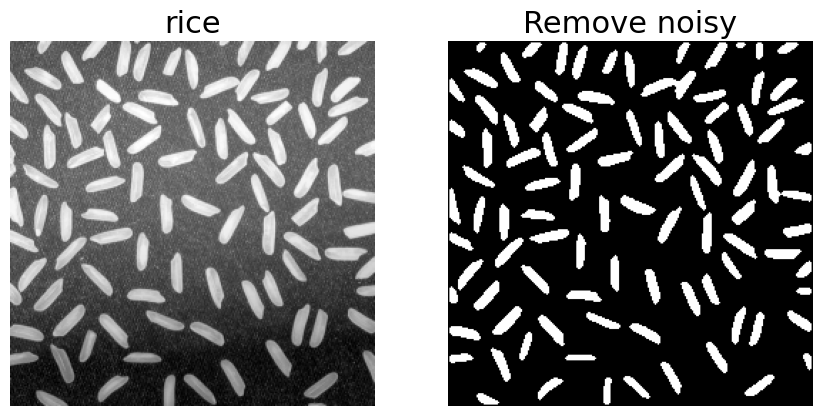

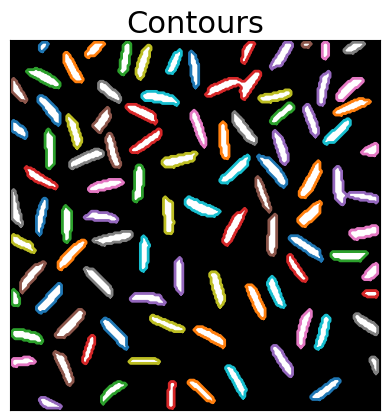

<Figure size 2400x700 with 0 Axes>

In [388]:
image = readGrayscaleimage('./Imagenes Lab U03./B/rice.png')

threshold = threshold_otsu(image) 

grayImage=image
name = 'rice'
threshold=threshold,
structural_element=diamond(radius=1)


plt.figure(figsize=(16,7)) # size of image

#original image
plt.subplot(1, 3, 1)
plt.imshow(grayImage, cmap= plt.cm.gray)
plt.title(f'{name}', fontsize=22)
plt.axis('off')



kernel = np.zeros((3,3), np.uint8) 
kernel[0:,1]=1
kernel[1,0:]=1

grayImage=median(grayImage,structural_element)
clahe = cv.createCLAHE(clipLimit=2, tileGridSize=(9,9))
grayImage = clahe.apply(grayImage)


G = np.where(grayImage > threshold, 1, 0) #return binary array
G = np.uint8(G)
G = G * 255
plt.subplot(1, 3, 2)
plt.imshow(G, cmap= plt.cm.gray) #show gray level  (2 levels)
plt.title('Binary', fontsize=22)
plt.axis('off')

G = np.where(grayImage > threshold, 1, 0) #return binary array
G = np.uint8(G)
G = binary_erosion(input=G, structure= structural_element)
G = binary_opening(input=G, structure= structural_element)
G = binary_closing(input=G, structure= structural_element)

G1 = G * 255
plt.subplot(1, 3, 2)
plt.imshow(G1, cmap= plt.cm.gray) #show gray level  (2 levels)
plt.title('Remove noisy', fontsize=22)
plt.axis('off')


_, number_objects8 = cv.connectedComponents(np.uint8(G),connectivity=8)
number_objects8 = number_objects8.max() 

_, number_objects4 = cv.connectedComponents(np.uint8(G),connectivity=4)
number_objects4 = number_objects4.max()


e4 = euler_number(np.uint8(G), connectivity=1)


contours = find_contours(G, 0.8)
fig, ax = plt.subplots()
ax.imshow(G, cmap=plt.cm.gray)
plt.title('Contours', fontsize=22)
plt.figure(figsize=(24,7))
for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
ax.set_xticks([])
ax.set_yticks([])   
    
G =img_as_ubyte(G)    
descriptor = regionprops(G)

print("Umbral de binarización:", threshold[0])
print("Conteo")
print("#################")
print("Número de componentes conexos con 8 conectividad:", number_objects8)
print("Número de componentes conexos con 4 conectividad:", number_objects4)
print("Número de componentes Euler:", e4)
print("Descriptores")
print("#################")
print("Perímetro:", descriptor[0].perimeter)
print("Area:", descriptor[0].area)
print("Excentricidad:", descriptor[0].eccentricity)
print("Orientación:", descriptor[0].orientation)

Umbral de binarización: 236
Conteo
#################
Número de componentes conexos con 8 conectividad: 3
Número de componentes conexos con 4 conectividad: 3
Número de componentes Euler: 3
Descriptores
#################
Perímetro: 671.3696244092001
Area: 8899
Orientación: -1.560809251187604
Excentricidad: 0.8979548771032614


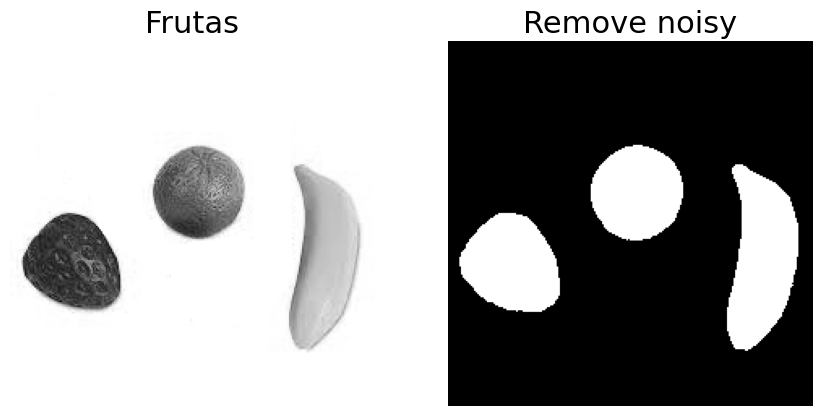

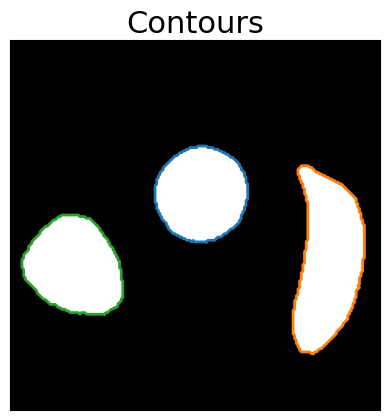

<Figure size 2400x700 with 0 Axes>

In [389]:
image = readGrayscaleimage('./Imagenes Lab U03./B/frutas.png')
#image = filter_2D.minimum_filter(image, size=11, footprint=None, output=None, mode='reflect', cval=0.0, origin=0)
threshold = threshold_isodata(image) + 50

grayImage=image
name = 'Frutas'
threshold=threshold,
structural_element=diamond(radius=1)


plt.figure(figsize=(16,7)) # size of image

#original image
plt.subplot(1, 3, 1)
plt.imshow(grayImage, cmap= plt.cm.gray)
plt.title(f'{name}', fontsize=22)
plt.axis('off')



kernel = np.zeros((3,3), np.uint8) 
kernel[0:,1]=1
kernel[1,0:]=1

#grayImage=median(grayImage,structural_element)
#clahe = cv.createCLAHE(clipLimit=2, tileGridSize=(9,9))
#grayImage = clahe.apply(grayImage)


G = np.where(grayImage > threshold, 1, 0) #return binary array
G = np.uint8(G)
G = G * 255
plt.subplot(1, 3, 2)
plt.imshow(G, cmap= plt.cm.gray) #show gray level  (2 levels)
plt.title('Binary', fontsize=22)
plt.axis('off')

G = np.where(grayImage < threshold, 1, 0) #return binary array
G = np.uint8(G)
#G = binary_erosion(input=G, structure= structural_element)
G = binary_opening(input=G, structure= structural_element)
G = binary_closing(input=G, structure= structural_element)

G1 = G * 255
plt.subplot(1, 3, 2)
plt.imshow(G1, cmap= plt.cm.gray) #show gray level  (2 levels)
plt.title('Remove noisy', fontsize=22)
plt.axis('off')


_, number_objects8 = cv.connectedComponents(np.uint8(G),connectivity=8)
number_objects8 = number_objects8.max()

_, number_objects4 = cv.connectedComponents(np.uint8(G),connectivity=4)
number_objects4 = number_objects4.max() 

e4 = euler_number(np.uint8(G), connectivity=1)


contours = find_contours(G, 0.8)
fig, ax = plt.subplots()
ax.imshow(G, cmap=plt.cm.gray)
plt.title('Contours', fontsize=22)
plt.figure(figsize=(24,7))
for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
ax.set_xticks([])
ax.set_yticks([])   
    
G =img_as_ubyte(G)    
descriptor = regionprops(G)
descriptor1 = regionprops(grayImage)
print("Umbral de binarización:", threshold[0])
print("Conteo")
print("#################")
print("Número de componentes conexos con 8 conectividad:", number_objects8)
print("Número de componentes conexos con 4 conectividad:", number_objects4)
print("Número de componentes Euler:", e4)
print("Descriptores")
print("#################")
print("Perímetro:", descriptor[0].perimeter)
print("Area:", descriptor[0].area)
print("Orientación:", descriptor[0].orientation)
print("Excentricidad:", descriptor[0].eccentricity)

Umbral de binarización: 78
Conteo
#################
Número de componentes conexos con 8 conectividad: 10
Número de componentes conexos con 4 conectividad: 10
Número de componentes Euler: 10
Descriptores
#################
Perímetro: 1801.540330732677
Area: 24118
Excentricidad: 0.6538212838202226
Orientación: 1.5058512799883912


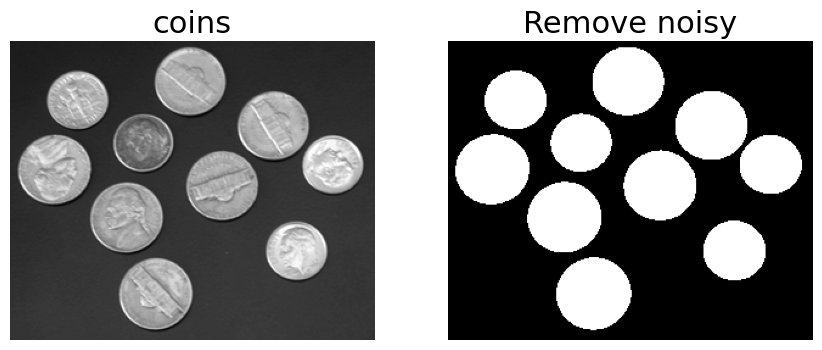

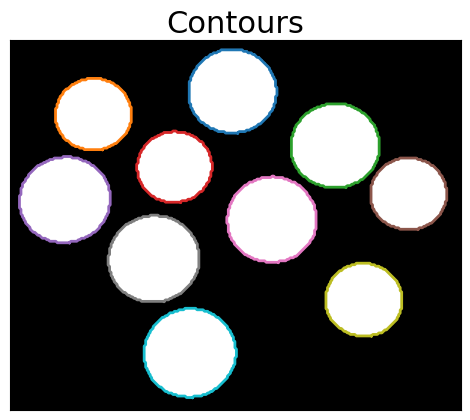

<Figure size 2400x700 with 0 Axes>

In [390]:
image = readGrayscaleimage('./Imagenes Lab U03./B/coins.png')
#image = filter_2D.minimum_filter(image, size=11, footprint=None, output=None, mode='reflect', cval=0.0, origin=0)
threshold = kapur_threshold(image)

grayImage=image
name = 'coins'
threshold=threshold
structural_element=diamond(radius=1)


plt.figure(figsize=(16,7)) # size of image

#original image
plt.subplot(1, 3, 1)
plt.imshow(grayImage, cmap= plt.cm.gray)
plt.title(f'{name}', fontsize=22)
plt.axis('off')



kernel = np.zeros((3,3), np.uint8) 
kernel[0:,1]=1
kernel[1,0:]=1

#grayImage=median(grayImage,structural_element)
#clahe = cv.createCLAHE(clipLimit=2, tileGridSize=(9,9))
#grayImage = clahe.apply(grayImage)


G = np.where(grayImage > threshold, 1, 0) #return binary array
G = np.uint8(G)
G = G * 255
plt.subplot(1, 3, 2)
plt.imshow(G, cmap= plt.cm.gray) #show gray level  (2 levels)
plt.title('Binary', fontsize=22)
plt.axis('off')

G = np.where(grayImage > threshold, 1, 0) #return binary array
G = np.uint8(G)
#G = binary_erosion(input=G, structure= structural_element)
G = binary_opening(input=G, structure= structural_element)
G = binary_closing(input=G, structure= structural_element)

G1 = G * 255
plt.subplot(1, 3, 2)
plt.imshow(G1, cmap= plt.cm.gray) #show gray level  (2 levels)
plt.title('Remove noisy', fontsize=22)
plt.axis('off')


_, number_objects8 = cv.connectedComponents(np.uint8(G),connectivity=8)
number_objects8 = number_objects8.max()

_, number_objects4 = cv.connectedComponents(np.uint8(G),connectivity=4)
number_objects4 = number_objects4.max() 

e4 = euler_number(np.uint8(G), connectivity=1)


contours = find_contours(G, 0.8)
fig, ax = plt.subplots()
ax.imshow(G, cmap=plt.cm.gray)
plt.title('Contours', fontsize=22)
plt.figure(figsize=(24,7))
for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
ax.set_xticks([])
ax.set_yticks([])   
    
G =img_as_ubyte(G)    
descriptor = regionprops(G)
print("Umbral de binarización:", threshold)
print("Conteo")
print("#################")
print("Número de componentes conexos con 8 conectividad:", number_objects8)
print("Número de componentes conexos con 4 conectividad:", number_objects4)
print("Número de componentes Euler:", e4)
print("Descriptores")
print("#################")
print("Perímetro:", descriptor[0].perimeter)
print("Area:", descriptor[0].area)
print("Excentricidad:", descriptor[0].eccentricity)
print("Orientación:", descriptor[0].orientation)

Umbral de binarización: 81
Conteo
#################
Número de componentes conexos con 8 conectividad: 8
Número de componentes conexos con 4 conectividad: 8
Número de componentes Euler: 8
Descriptores
#################
Perímetro: 4676.688742479566
Area: 154695
Orientacion: -0.013126259050768892
Excentricidad: 0.6479994247282306


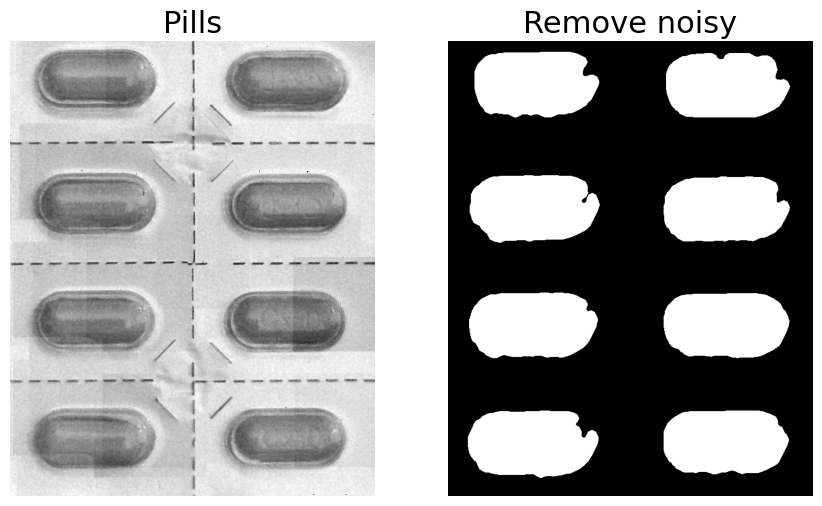

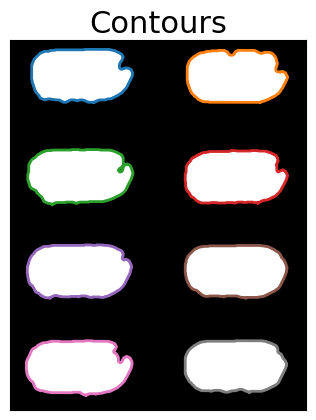

<Figure size 2400x700 with 0 Axes>

In [391]:
imageGray = readGrayscaleimage('./Imagenes Lab U03./B/pills.png')
name = 'Pills'

DER = grey_dilation(imageGray,155)
imageGray = imageGray  - DER

image = imageGray.copy()
kernel = np.zeros((5,5), np.uint8) 
kernel[0:,1]=1
kernel[1,0:]=1
Kernel = disk(5)
kerneld=disk(5)
kernero=disk(3)
kern=disk(3)
image=255-image


image=median(image,kernel)
image=median(image,kernel)
image=median(image,kernel)
image=median(image,kernel)

image=median(image,kernel)
image=median(image,kernel)
image=median(image,kernel)





plt.figure(figsize=(16,7)) # size of image
plt.subplot(1, 3, 1)
plt.imshow(imageGray, cmap= plt.cm.gray)
plt.title(f'{name}', fontsize=22)
plt.axis('off')


threshold = threshold_otsu(image) - 2
G = np.where(image > threshold, 1, 0) #return binary array
G = np.uint8(G)
G = G * 255



plt.subplot(1, 3, 2)
plt.imshow(G, cmap= plt.cm.gray) #show gray level  (2 levels)
plt.title('Binary', fontsize=22)
plt.axis('off')

G = binary_closing(input=G, structure= kerneld)
G = binary_opening(input=G, structure= kerneld)


G = binary_erosion(input=G, structure= kern)
G = binary_erosion(input=G, structure= kern)





G = binary_dilation(input=G, structure= kern)
G = binary_dilation(input=G, structure= kern)
G = binary_dilation(input=G, structure= kern)


plt.subplot(1, 3, 2)
plt.imshow(G, cmap= plt.cm.gray) #show gray level  (2 levels)
plt.title('Remove noisy', fontsize=22)
plt.axis('off')


_, number_objects8 = cv.connectedComponents(np.uint8(G),connectivity=8)
number_objects8 = number_objects8.max()

_, number_objects4 = cv.connectedComponents(np.uint8(G),connectivity=4)
number_objects4 = number_objects4.max() 

e4 = euler_number(np.uint8(G), connectivity=1)


contours = find_contours(G, 0.8)
fig, ax = plt.subplots()
ax.imshow(G, cmap=plt.cm.gray)
plt.title('Contours', fontsize=22)
plt.figure(figsize=(24,7))
for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
ax.set_xticks([])
ax.set_yticks([])   
    
G =img_as_ubyte(G)    
descriptor = regionprops(G)
print("Umbral de binarización:", threshold)
print("Conteo")
print("#################")
print("Número de componentes conexos con 8 conectividad:", number_objects8)
print("Número de componentes conexos con 4 conectividad:", number_objects4)
print("Número de componentes Euler:", e4)
print("Descriptores")
print("#################")
print("Perímetro:", descriptor[0].perimeter)
print("Area:", descriptor[0].area)
print("Orientacion:", descriptor[0].orientation)
print("Excentricidad:", descriptor[0].eccentricity)

Umbral de binarización: 170
Conteo
#################
Número de componentes conexos con 8 conectividad: 2
Número de componentes conexos con 4 conectividad: 2
Número de componentes Euler: 2
Descriptores
#################
Perímetro: 537.8132752230961
Area: 9843
Orientación: 1.331386967374149
Excentricidad: 0.9762473631471664


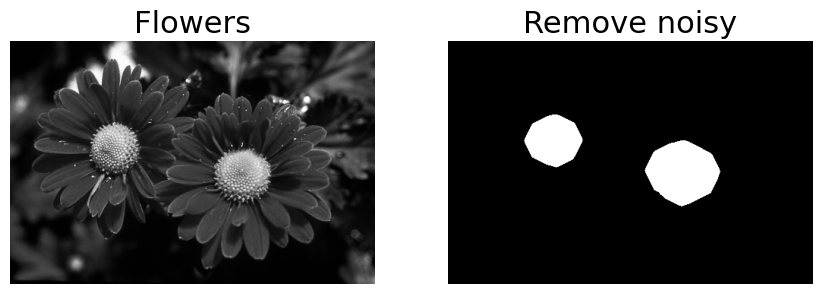

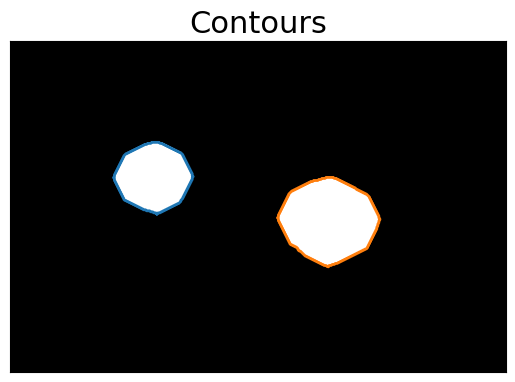

<Figure size 2400x700 with 0 Axes>

In [392]:
imageGray = readGrayscaleimage('./Imagenes Lab U03./B/124084.png')
name = 'Flowers'

image = filter_2D.minimum_filter(imageGray, size=11, footprint=None, output=None, mode='reflect', cval=0.0, origin=0)




kernel = np.zeros((5,5), np.uint8) 
kernel[0:,1]=1
kernel[1,0:]=1
Kernel = disk(3)
kerneld=disk(5)
kernero=disk(3)
kern=disk(3)
image=255-image


image=median(image,kernel)
image=median(image,kernel)
image=median(image,kernel)






plt.figure(figsize=(16,7)) # size of image
plt.subplot(1, 3, 1)
plt.imshow(imageGray, cmap= plt.cm.gray)
plt.title(f'{name}', fontsize=22)
plt.axis('off')


threshold = threshold_otsu(image) - 50
G = np.where(image < threshold, 1, 0) #return binary array
G = np.uint8(G)
G = G * 255



plt.subplot(1, 3, 2)
plt.imshow(G, cmap= plt.cm.gray) #show gray level  (2 levels)
plt.title('Binary', fontsize=22)
plt.axis('off')


G = binary_closing(input=G, structure= kerneld)
G = binary_opening(input=G, structure= kerneld)

#G = binary_erosion(input=G, structure= kern)
#G = binary_erosion(input=G, structure= kern)

G = binary_erosion(input=G, structure= kern)
G = binary_erosion(input=G, structure= kern)
#G = binary_erosion(input=G, structure= kern)

G = binary_closing(input=G, structure= kerneld)
G = binary_opening(input=G, structure= kerneld)

G = binary_dilation(input=G, structure= kern)
G = binary_dilation(input=G, structure= kern)
G = binary_dilation(input=G, structure= kern)
G = binary_dilation(input=G, structure= kern)
G = binary_dilation(input=G, structure= kern)
G = binary_dilation(input=G, structure= kern)
G = binary_dilation(input=G, structure= kern)
G = binary_dilation(input=G, structure= kern)
G = binary_dilation(input=G, structure= kern)
#G = binary_dilation(input=G, structure= kern)
#G = binary_dilation(input=G, structure= kern)
#G = binary_dilation(input=G, structure= kern)




plt.subplot(1, 3, 2)
plt.imshow(G, cmap= plt.cm.gray) #show gray level  (2 levels)
plt.title('Remove noisy', fontsize=22)
plt.axis('off')


_, number_objects8 = cv.connectedComponents(np.uint8(G),connectivity=8)
number_objects8 = number_objects8.max()

_, number_objects4 = cv.connectedComponents(np.uint8(G),connectivity=4)
number_objects4 = number_objects4.max() 

e4 = euler_number(np.uint8(G), connectivity=1)


contours = find_contours(G, 0.8)
fig, ax = plt.subplots()
ax.imshow(G, cmap=plt.cm.gray)
plt.title('Contours', fontsize=22)
plt.figure(figsize=(24,7))
for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
ax.set_xticks([])
ax.set_yticks([])   
    
G =img_as_ubyte(G)    
descriptor = regionprops(G)
print("Umbral de binarización:", threshold)
print("Conteo")
print("#################")
print("Número de componentes conexos con 8 conectividad:", number_objects8)
print("Número de componentes conexos con 4 conectividad:", number_objects4)
print("Número de componentes Euler:", e4)
print("Descriptores")
print("#################")
print("Perímetro:", descriptor[0].perimeter)
print("Area:", descriptor[0].area)
print("Orientación:", descriptor[0].orientation)
print("Excentricidad:", descriptor[0].eccentricity)

Umbral de binarización: 0.03074690784652591
Conteo
#################
Número de componentes conexos con 8 conectividad: 176
Número de componentes conexos con 4 conectividad: 196
Número de componentes Euler: 196
Descriptores
#################
Perímetro: 3636.5469657933345
Area: 5705
Excentricidad: 0.5483728389882676
Orientación: -1.4575211514986375


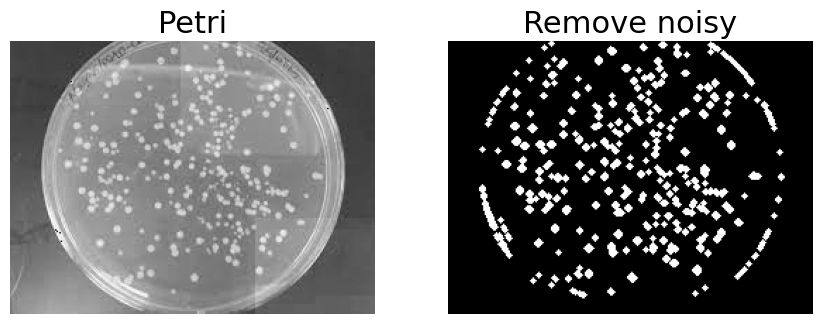

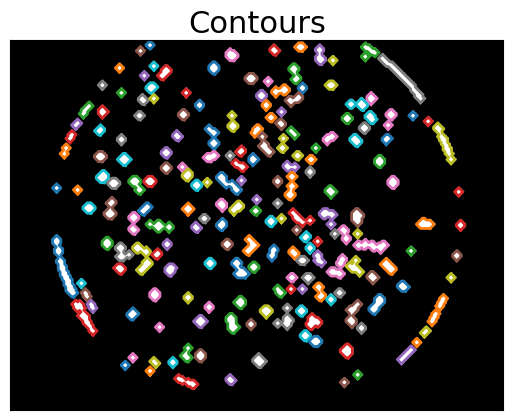

<Figure size 2400x700 with 0 Axes>

In [393]:
imageGray = readGrayscaleimage('./Imagenes Lab U03./B/petri.jpg')
name = 'Petri'

DER = grey_dilation(imageGray,155)
imageGray = imageGray  - DER
kernero=disk(2)
kern=disk(1)
image = imageGray.copy()
image = gaussian(image, 1)
image = laplace(image, 3)
threshold = threshold_otsu(image) 



plt.figure(figsize=(16,7)) # size of image
plt.subplot(1, 3, 1)
plt.imshow(imageGray, cmap= plt.cm.gray)
plt.title(f'{name}', fontsize=22)
plt.axis('off')



G = np.where(image > threshold, 1, 0) #return binary array
G = np.uint8(G)
G = G * 255

G = binary_erosion(input=G, structure= kern)
G = binary_dilation(input=G, structure= kern)
G = binary_dilation(input=G, structure= kern)
#G = binary_erosion(input=G, structure= kern)
#G = binary_dilation(input=G, structure= kern)

#G = binary_erosion(input=G, structure= kern)

plt.subplot(1, 3, 2)
plt.imshow(G, cmap= plt.cm.gray) #show gray level  (2 levels)
plt.title('Binary', fontsize=22)
plt.axis('off')



plt.subplot(1, 3, 2)
plt.imshow(G, cmap= plt.cm.gray) #show gray level  (2 levels)
plt.title('Remove noisy', fontsize=22)
plt.axis('off')


_, number_objects8 = cv.connectedComponents(np.uint8(G),connectivity=8)
number_objects8 = number_objects8.max()

_, number_objects4 = cv.connectedComponents(np.uint8(G),connectivity=4)
number_objects4 = number_objects4.max() 

e4 = euler_number(np.uint8(G), connectivity=1)


contours = find_contours(G, 0.8)
fig, ax = plt.subplots()
ax.imshow(G, cmap=plt.cm.gray)
plt.title('Contours', fontsize=22)
plt.figure(figsize=(24,7))
for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
ax.set_xticks([])
ax.set_yticks([])   
    
G =img_as_ubyte(G)    
descriptor = regionprops(G)
print("Umbral de binarización:", threshold)
print("Conteo")
print("#################")
print("Número de componentes conexos con 8 conectividad:", number_objects8)
print("Número de componentes conexos con 4 conectividad:", number_objects4)
print("Número de componentes Euler:", e4)
print("Descriptores")
print("#################")
print("Perímetro:", descriptor[0].perimeter)
print("Area:", descriptor[0].area)
print("Excentricidad:", descriptor[0].eccentricity)
print("Orientación:", descriptor[0].orientation)

Umbral de binarización: 103
Conteo
#################
Número de componentes conexos con 8 conectividad: 28
Número de componentes conexos con 4 conectividad: 29
Número de componentes Euler: 29
Descriptores
#################
Perímetro: 1758.670273047588
Area: 7816
Excentricidad: 1.144386755878753
Orientación: 1.144386755878753


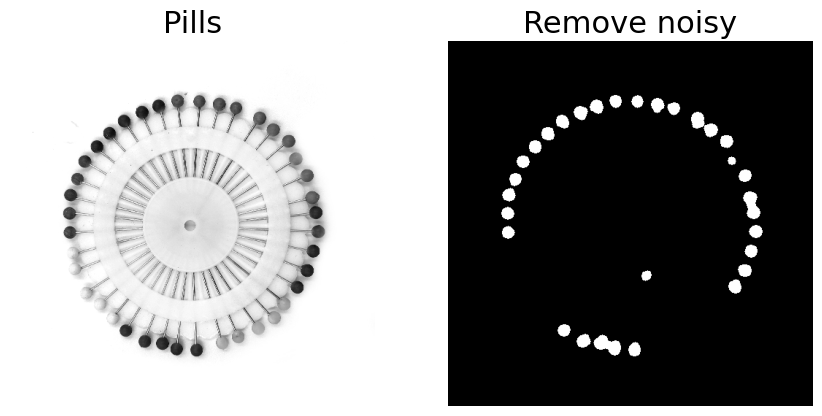

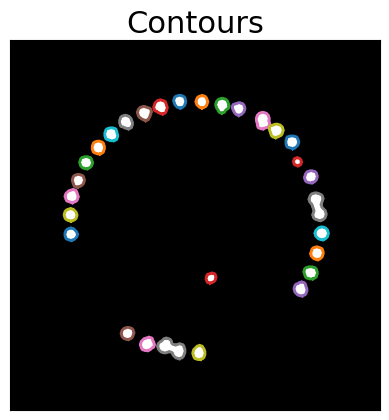

<Figure size 2400x700 with 0 Axes>

In [402]:
imageGray = readGrayscaleimage('./Imagenes Lab U03./B/alfilere2.jpg')
name = 'Pills'
image = imageGray.copy()

kernero=disk(2)
kern=disk(1)
image = imageGray
image = median(image,kern)
image =  black_tophat(image,size=325)
threshold = threshold_otsu(image)  + 40



plt.figure(figsize=(16,7)) # size of image
plt.subplot(1, 3, 1)
plt.imshow(imageGray, cmap= plt.cm.gray)
plt.title(f'{name}', fontsize=22)
plt.axis('off')



G = np.where(image > threshold, 1, 0) #return binary array
G = np.uint8(G)
G = G * 255



G = binary_erosion(input=G, structure= square(1))
G = binary_erosion(input=G, structure= square(1))
G = binary_closing(input=G, structure= kerneld)
G = binary_opening(input=G, structure= kerneld)

plt.subplot(1, 3, 2)
plt.imshow(G, cmap= plt.cm.gray) #show gray level  (2 levels)
plt.title('Binary', fontsize=22)
plt.axis('off')



plt.subplot(1, 3, 2)
plt.imshow(G, cmap= plt.cm.gray) #show gray level  (2 levels)
plt.title('Remove noisy', fontsize=22)
plt.axis('off')


_, number_objects8 = cv.connectedComponents(np.uint8(G),connectivity=8)
number_objects8 = number_objects8.max()

_, number_objects4 = cv.connectedComponents(np.uint8(G),connectivity=4)
number_objects4 = number_objects4.max() 

e4 = euler_number(np.uint8(G), connectivity=1)


contours = find_contours(G, 0.8)
fig, ax = plt.subplots()
ax.imshow(G, cmap=plt.cm.gray)
plt.title('Contours', fontsize=22)
plt.figure(figsize=(24,7))
for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
ax.set_xticks([])
ax.set_yticks([])   
    
G =img_as_ubyte(G)    
descriptor = regionprops(G)
print("Umbral de binarización:", threshold)
print("Conteo")
print("#################")
print("Número de componentes conexos con 8 conectividad:", number_objects8)
print("Número de componentes conexos con 4 conectividad:", number_objects4)
print("Número de componentes Euler:", e4)
print("Descriptores")
print("#################")
print("Perímetro:", descriptor[0].perimeter)
print("Area:", descriptor[0].area)
print("Excentricidad:", descriptor[0].orientation)
print("Orientación:", descriptor[0].orientation)

<h1> Reconocimiento de patrones </h1>
    

<h2> 1.1. Librerias </h2> 


seaborn -> matplotlib
sckikit-learn -> Algoritmos Machine Learning
pandas -> dataframes -> Tablas (filas columas tipos de datos?)

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris

para lab nos va a dar urls, (capaz de kaggle). Para proyecto se pueden empaquetar los dataset y luego desempaquetarlos con la libreria sklearn?


Pasos a seguir:
1.- Recuperando datos
2.- Analizar los datos
3. Transformacion de datos (preprocesamiento)
clases balanceadas si tienen la misma cantidad de patrones, +/-1 no hay problema,
cuando se esta desbalanceado cambian las metricas
las metricas funcionan bien con clases balanceadas y los datos son numericos

<h2> 1.2. Acceder a dataset </h2> 

<h2> 1.2.1. Importar desde libreria </h2> 

### Datos de test

In [103]:
path = './dataset/image+segmentation/segmentation.data'
separador= ',' 
df_test = pd.read_csv(path, sep=separador)
df_test

CLASSES  REGION-CENTROID-COL  REGION-CENTROID-ROW  REGION-PIXEL-COUNT  \
0    BRICKFACE                140.0                125.0                   9   
1    BRICKFACE                188.0                133.0                   9   
2    BRICKFACE                105.0                139.0                   9   
3    BRICKFACE                 34.0                137.0                   9   
4    BRICKFACE                 39.0                111.0                   9   
..         ...                  ...                  ...                 ...   
205      GRASS                 36.0                243.0                   9   
206      GRASS                186.0                218.0                   9   
207      GRASS                197.0                236.0                   9   
208      GRASS                208.0                240.0                   9   
209      GRASS                223.0                185.0                   9   

     SHORT-LINE-DENSITY-5  SHORT-LINE-DENSITY-2  VEDGE-MEAN  VEDGE-SD  \
0                0.000000                   0.0    0.277778  0.062963   
1                0.000000                   0.0    0.333333  0.266667   
2                0.000000                   0.0    0.277778  0.107407   
3                0.000000                   0.0    0.500000  0.166667   
4                0.000000                   0.0    0.722222  0.374074   
..                    ...                   ...         ...       ...   
205              0.111111                   0.0    1.888889  1.851851   
206              0.000000                   0.0    1.166667  0.744444   
207              0.000000                   0.0    2.444444  6.829628   
208              0.111111                   0.0    1.055556  0.862963   
209              0.000000                   0.0    0.500000  0.349603   

     HEDGE-MEAN  HEDGE-SD  INTENSITY-MEAN  RAWRED-MEAN  RAWBLUE-MEAN  \
0      0.666667  0.311111        6.185185     7.333334      7.666666   
1      0.500000  0.077778        6.666666     8.333334      7.777778   
2      0.833333  0.522222        6.111111     7.555555      7.222222   
3      1.111111  0.474074        5.851852     7.777778      6.444445   
4      0.888889  0.429629        6.037037     7.000000      7.666666   
..          ...       ...             ...          ...           ...   
205    2.000000  0.711110       13.333333     9.888889     12.111111   
206    1.166667  0.655555       13.703704    10.666667     12.666667   
207    3.333333  7.599998       16.074074    13.111111     16.666668   
208    2.444444  5.007407       14.148149    10.888889     13.000000   
209    2.388889  2.080776       12.962963    11.555555      9.777778   

     RAWGREEN-MEAN  EXRED-MEAN  EXBLUE-MEAN  EXGREEN-MEAN  VALUE-MEAN  \
0         3.555556    3.444444     4.444445     -7.888889    7.777778   
1         3.888889    5.000000     3.333333     -8.333333    8.444445   
2         3.555556    4.333334     3.333333     -7.666666    7.555555   
3         3.333333    5.777778     1.777778     -7.555555    7.777778   
4         3.444444    2.888889     4.888889     -7.777778    7.888889   
..             ...         ...          ...           ...         ...   
205      18.000000  -10.333333    -3.666667     14.000000   18.000000   
206      17.777779   -9.111111    -3.111111     12.222222   17.777779   
207      18.444445   -8.888889     1.777778      7.111111   18.555555   
208      18.555555   -9.777778    -3.444444     13.222222   18.555555   
209      17.555555   -4.222222    -9.555555     13.777778   17.555555   

     SATURATION-MEAN  HUE-MEAN  
0           0.545635 -1.121818  
1           0.538580 -0.924817  
2           0.532628 -0.965946  
3           0.573633 -0.744272  
4           0.562919 -1.175773  
..               ...       ...  
205         0.452229  2.368311  
206         0.401347  2.382684  
207         0.292729  2.789800  
208         0.421621  2.392487  
209         0.445418  1.838850  

[210 rows x 20 columns]

### Datos de train

In [105]:
path = './dataset/image+segmentation/segmentation.test'
separador= ',' 
df_train = pd.read_csv(path, sep=separador)
df_train

CLASSES  REGION-CENTROID-COL  REGION-CENTROID-ROW  REGION-PIXEL-COUNT  \
0      GRASS                110.0                189.0                   9   
1      GRASS                 86.0                187.0                   9   
2      GRASS                225.0                244.0                   9   
3      GRASS                 47.0                232.0                   9   
4      GRASS                 97.0                186.0                   9   
...      ...                  ...                  ...                 ...   
2095  CEMENT                 32.0                158.0                   9   
2096  CEMENT                  8.0                162.0                   9   
2097  CEMENT                128.0                161.0                   9   
2098  CEMENT                150.0                158.0                   9   
2099  CEMENT                124.0                162.0                   9   

      SHORT-LINE-DENSITY-5  SHORT-LINE-DENSITY-2  VEDGE-MEAN  VEDGE-SD  \
0                 0.000000                   0.0    1.000000  0.666667   
1                 0.000000                   0.0    1.111111  0.720082   
2                 0.000000                   0.0    3.388889  2.195113   
3                 0.000000                   0.0    1.277778  1.254621   
4                 0.000000                   0.0    1.166667  0.691215   
...                    ...                   ...         ...       ...   
2095              0.000000                   0.0    0.944445  0.862963   
2096              0.111111                   0.0    1.611111  2.062962   
2097              0.000000                   0.0    0.555555  0.251852   
2098              0.000000                   0.0    2.166667  1.633334   
2099              0.111111                   0.0    1.388889  1.129630   

      HEDGE-MEAN  HEDGE-SD  INTENSITY-MEAN  RAWRED-MEAN  RAWBLUE-MEAN  \
0       1.222222  1.186342       12.925926    10.888889      9.222222   
1       1.444444  0.750309       13.740741    11.666667     10.333334   
2       3.000000  1.520234       12.259259    10.333334      9.333334   
3       1.000000  0.894427       12.703704    11.000000      9.000000   
4       1.166667  1.005540       15.592592    13.888889     11.777778   
...          ...       ...             ...          ...           ...   
2095    0.833333  0.611111        7.962963     6.333334     11.888889   
2096    0.333333  0.133333        8.370370     6.666666     12.000000   
2097    0.777778  0.162963        7.148148     5.555555     10.888889   
2098    1.388889  0.418518        8.444445     7.000000     12.222222   
2099    2.000000  0.888889       10.037037     8.000000     14.555555   

      RAWGREEN-MEAN  EXRED-MEAN  EXBLUE-MEAN  EXGREEN-MEAN  VALUE-MEAN  \
0         18.666668   -6.111111   -11.111111     17.222221   18.666668   
1         19.222221   -6.222222   -10.222222     16.444445   19.222221   
2         17.111110   -5.777778    -8.777778     14.555555   17.111110   
3         18.111110   -5.111111   -11.111111     16.222221   18.111110   
4         21.111110   -5.111111   -11.444445     16.555555   21.111110   
...             ...         ...          ...           ...         ...   
2095       5.666666   -4.888889    11.777778     -6.888889   11.888889   
2096       6.444445   -5.111111    10.888889     -5.777778   12.000000   
2097       5.000000   -4.777778    11.222222     -6.444445   10.888889   
2098       6.111111   -4.333334    11.333333     -7.000000   12.222222   
2099       7.555555   -6.111111    13.555555     -7.444445   14.555555   

      SATURATION-MEAN  HUE-MEAN  
0            0.508139  1.910864  
1            0.463329  1.941465  
2            0.480149  1.987902  
3            0.500966  1.875362  
4            0.442661  1.863654  
...               ...       ...  
2095         0.520578 -1.982834  
2096         0.484805 -2.044946  
2097         0.540918 -1.996307  
2098         0.503086 -1.943449  
2099         0.479931 -2.029312  

[210

<h2> 1.2.2. Importar desde URL </h2> 

https://archive.ics.uci.edu/

<h2> 1.3 Visualizando el dataframe </h2> 

### Dominio de datos del cojunto de entrenamiento

In [106]:
print(df_train.dtypes)

CLASSES                  object
REGION-CENTROID-COL     float64
REGION-CENTROID-ROW     float64
REGION-PIXEL-COUNT        int64
SHORT-LINE-DENSITY-5    float64
SHORT-LINE-DENSITY-2    float64
VEDGE-MEAN              float64
VEDGE-SD                float64
HEDGE-MEAN              float64
HEDGE-SD                float64
INTENSITY-MEAN          float64
RAWRED-MEAN             float64
RAWBLUE-MEAN            float64
RAWGREEN-MEAN           float64
EXRED-MEAN              float64
EXBLUE-MEAN             float64
EXGREEN-MEAN            float64
VALUE-MEAN              float64
SATURATION-MEAN         float64
HUE-MEAN                float64
dtype: object


In [107]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2100 entries, 0 to 2099
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CLASSES               2100 non-null   object 
 1   REGION-CENTROID-COL   2100 non-null   float64
 2   REGION-CENTROID-ROW   2100 non-null   float64
 3   REGION-PIXEL-COUNT    2100 non-null   int64  
 4   SHORT-LINE-DENSITY-5  2100 non-null   float64
 5   SHORT-LINE-DENSITY-2  2100 non-null   float64
 6   VEDGE-MEAN            2100 non-null   float64
 7   VEDGE-SD              2100 non-null   float64
 8   HEDGE-MEAN            2100 non-null   float64
 9   HEDGE-SD              2100 non-null   float64
 10  INTENSITY-MEAN        2100 non-null   float64
 11  RAWRED-MEAN           2100 non-null   float64
 12  RAWBLUE-MEAN          2100 non-null   float64
 13  RAWGREEN-MEAN         2100 non-null   float64
 14  EXRED-MEAN            2100 non-null   float64
 15  EXBLUE-MEAN          

### Dominio de datos del cojunto de entrenamiento

In [108]:
print(df_test.dtypes)

CLASSES                  object
REGION-CENTROID-COL     float64
REGION-CENTROID-ROW     float64
REGION-PIXEL-COUNT        int64
SHORT-LINE-DENSITY-5    float64
SHORT-LINE-DENSITY-2    float64
VEDGE-MEAN              float64
VEDGE-SD                float64
HEDGE-MEAN              float64
HEDGE-SD                float64
INTENSITY-MEAN          float64
RAWRED-MEAN             float64
RAWBLUE-MEAN            float64
RAWGREEN-MEAN           float64
EXRED-MEAN              float64
EXBLUE-MEAN             float64
EXGREEN-MEAN            float64
VALUE-MEAN              float64
SATURATION-MEAN         float64
HUE-MEAN                float64
dtype: object


In [109]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CLASSES               210 non-null    object 
 1   REGION-CENTROID-COL   210 non-null    float64
 2   REGION-CENTROID-ROW   210 non-null    float64
 3   REGION-PIXEL-COUNT    210 non-null    int64  
 4   SHORT-LINE-DENSITY-5  210 non-null    float64
 5   SHORT-LINE-DENSITY-2  210 non-null    float64
 6   VEDGE-MEAN            210 non-null    float64
 7   VEDGE-SD              210 non-null    float64
 8   HEDGE-MEAN            210 non-null    float64
 9   HEDGE-SD              210 non-null    float64
 10  INTENSITY-MEAN        210 non-null    float64
 11  RAWRED-MEAN           210 non-null    float64
 12  RAWBLUE-MEAN          210 non-null    float64
 13  RAWGREEN-MEAN         210 non-null    float64
 14  EXRED-MEAN            210 non-null    float64
 15  EXBLUE-MEAN           2

### Descripción del conjunto de entrenamiento

In [110]:
df_train.describe()
# Se observa que los datos necesitan una escalación para reducir el tamaño del dominio por ejemplo los valores de Pixel region count y region centroid col

REGION-CENTROID-COL  REGION-CENTROID-ROW  REGION-PIXEL-COUNT  \
count          2100.000000          2100.000000              2100.0   
mean            124.940476           123.483333                 9.0   
std              72.858637            57.431428                 0.0   
min               1.000000            11.000000                 9.0   
25%              62.000000            81.000000                 9.0   
50%             121.000000           122.000000                 9.0   
75%             188.250000           171.250000                 9.0   
max             254.000000           251.000000                 9.0   

       SHORT-LINE-DENSITY-5  SHORT-LINE-DENSITY-2   VEDGE-MEAN     VEDGE-SD  \
count           2100.000000           2100.000000  2100.000000  2100.000000   
mean               0.014921              0.004550     1.890820     5.708299   
std                0.041024              0.023573     2.649453    44.989359   
min                0.000000              0.000000     0.000000     0.000000   
25%                0.000000              0.000000     0.722222     0.349603   
50%                0.000000              0.000000     1.277776     0.833333   
75%                0.000000              0.000000     2.222221     1.807406   
max                0.333333              0.222222    29.222221   991.718400   

        HEDGE-MEAN      HEDGE-SD  INTENSITY-MEAN  RAWRED-MEAN  RAWBLUE-MEAN  \
count  2100.000000  2.100000e+03     2100.000000  2100.000000   2100.000000   
mean      2.406772  7.904224e+00       37.047654    32.806667     44.205556   
std       3.469954  5.347107e+01       38.135291    34.994538     43.510119   
min       0.000000 -1.589457e-08        0.000000     0.000000      0.000000   
25%       0.833332  4.216377e-01        7.472222     7.000000      9.666667   
50%       1.444444  9.897442e-01       21.666666    19.666668     27.777779   
75%       2.555556  2.251852e+00       53.277778    47.333332     65.000000   
max      44.722225  1.386329e+03      143.444440   137.111110    150.888890   

       RAWGREEN-MEAN   EXRED-MEAN  EXBLUE-MEAN  EXGREEN-MEAN   VALUE-MEAN  \
count    2100.000000  2100.000000  2100.000000   2100.000000  2100.000000   
mean       34.130741   -12.722963    21.473704     -8.750741    45.162381   
std        36.303768    11.588214    19.654107     11.606996    42.900582   
min         0.000000   -49.666668   -12.444445    -33.888890     0.000000   
25%         6.222222   -18.583333     4.305556    -17.000000    11.777778   
50%        20.444445   -10.888889    19.666666    -11.000000    28.666666   
75%        46.388888    -4.222222    36.111110     -3.222222    65.000000   
max       142.555560     9.888889    82.000000     24.666666   150.888890   

       SATURATION-MEAN     HUE-MEAN  
count      2100.000000  2100.000000  
mean          0.427259    -1.365147  
std           0.228458     1.544278  
min           0.000000    -3.044175  
25%           0.284934    -2.188539  
50%           0.375064    -2.052625  
75%           0.540228    -1.565745  
max           1.000000     2.912480

### Descripción del conjunto de test

In [111]:
df_test.describe()

REGION-CENTROID-COL  REGION-CENTROID-ROW  REGION-PIXEL-COUNT  \
count           210.000000           210.000000               210.0   
mean            124.647619           122.757143                 9.0   
std              74.104024            58.139686                 0.0   
min               1.000000            11.000000                 9.0   
25%              60.500000            81.500000                 9.0   
50%             123.500000           121.500000                 9.0   
75%             189.750000           174.500000                 9.0   
max             252.000000           250.000000                 9.0   

       SHORT-LINE-DENSITY-5  SHORT-LINE-DENSITY-2  VEDGE-MEAN    VEDGE-SD  \
count            210.000000            210.000000  210.000000  210.000000   
mean               0.008466              0.006349    1.925132    5.719529   
std                0.029549              0.030077    3.158211   43.495942   
min                0.000000              0.000000    0.000000    0.000000   
25%                0.000000              0.000000    0.666667    0.400921   
50%                0.000000              0.000000    1.222222    0.828695   
75%                0.000000              0.000000    1.888890    1.676634   
max                0.111111              0.222222   25.500000  572.996400   

       HEDGE-MEAN     HEDGE-SD  INTENSITY-MEAN  RAWRED-MEAN  RAWBLUE-MEAN  \
count  210.000000   210.000000      210.000000   210.000000    210.000000   
mean     2.604233    11.638377       37.091005    32.967725     44.011112   
std      4.798268    97.390023       38.677168    35.540563     43.804447   
min      0.000000     0.000000        0.000000     0.000000      0.000000   
25%      0.777779     0.410816        6.453704     7.000000      8.277778   
50%      1.388889     0.913176       21.314816    18.611112     26.833334   
75%      2.597221     1.980485       52.629629    46.750000     64.194447   
max     44.722225  1386.329200      143.444440   136.888890    150.888890   

       RAWGREEN-MEAN  EXRED-MEAN  EXBLUE-MEAN  EXGREEN-MEAN  VALUE-MEAN  \
count     210.000000  210.000000   210.000000    210.000000  210.000000   
mean       34.294180  -12.369841    20.760317     -8.390476   44.888360   
std        37.057003   11.559599    18.761842     11.003746   43.235182   
min         0.000000  -48.222220    -9.666667    -30.555555    0.000000   
25%         3.805555  -18.111110     4.111111    -15.750000   10.527778   
50%        20.000000  -10.333333    19.555556     -9.888889   28.388890   
75%        46.472223   -4.666666    34.333332     -3.722222   64.194447   
max       142.555560    5.777778    78.777780     21.888890  150.888890   

       SATURATION-MEAN    HUE-MEAN  
count       210.000000  210.000000  
mean          0.423230   -1.340397  
std           0.227333    1.559405  
min           0.000000   -2.530950  
25%           0.275722   -2.187112  
50%           0.365455   -2.044163  
75%           0.539738   -1.429800  
max           1.000000    2.864931

### Obtener clases del dataset

In [112]:
df_train.columns

Index(['CLASSES', 'REGION-CENTROID-COL', 'REGION-CENTROID-ROW',
       'REGION-PIXEL-COUNT', 'SHORT-LINE-DENSITY-5', 'SHORT-LINE-DENSITY-2',
       'VEDGE-MEAN', 'VEDGE-SD', 'HEDGE-MEAN', 'HEDGE-SD', 'INTENSITY-MEAN',
       'RAWRED-MEAN', 'RAWBLUE-MEAN', 'RAWGREEN-MEAN', 'EXRED-MEAN',
       'EXBLUE-MEAN', 'EXGREEN-MEAN', 'VALUE-MEAN', 'SATURATION-MEAN',
       'HUE-MEAN'],
      dtype='object')

In [113]:
df_train.groupby(['CLASSES']).size()

CLASSES
BRICKFACE    300
CEMENT       300
FOLIAGE      300
GRASS        300
PATH         300
SKY          300
WINDOW       300
dtype: int64

In [114]:
df_test.groupby(['CLASSES']).size()

CLASSES
BRICKFACE    30
CEMENT       30
FOLIAGE      30
GRASS        30
PATH         30
SKY          30
WINDOW       30
dtype: int64

### Volver Categorica la columna CLASSES entrenamiento

In [122]:
{'CLASSES': {categoria:indx for indx , categoria in enumerate(df_train['CLASSES'].unique())}}

{'CLASSES': {'GRASS': 0,
  'PATH': 1,
  'WINDOW': 2,
  'CEMENT': 3,
  'FOLIAGE': 4,
  'SKY': 5,
  'BRICKFACE': 6}}

In [125]:
clases = {'CLASSES': {categoria:indx for indx , categoria in enumerate(df_train['CLASSES'].unique())}}
data_train =df_train.replace(clases)


In [128]:
data_train.groupby(['CLASSES']).size()

CLASSES
0    300
1    300
2    300
3    300
4    300
5    300
6    300
dtype: int64

In [130]:
data_train

CLASSES  REGION-CENTROID-COL  REGION-CENTROID-ROW  REGION-PIXEL-COUNT  \
0           0                110.0                189.0                   9   
1           0                 86.0                187.0                   9   
2           0                225.0                244.0                   9   
3           0                 47.0                232.0                   9   
4           0                 97.0                186.0                   9   
...       ...                  ...                  ...                 ...   
2095        3                 32.0                158.0                   9   
2096        3                  8.0                162.0                   9   
2097        3                128.0                161.0                   9   
2098        3                150.0                158.0                   9   
2099        3                124.0                162.0                   9   

      SHORT-LINE-DENSITY-5  SHORT-LINE-DENSITY-2  VEDGE-MEAN  VEDGE-SD  \
0                 0.000000                   0.0    1.000000  0.666667   
1                 0.000000                   0.0    1.111111  0.720082   
2                 0.000000                   0.0    3.388889  2.195113   
3                 0.000000                   0.0    1.277778  1.254621   
4                 0.000000                   0.0    1.166667  0.691215   
...                    ...                   ...         ...       ...   
2095              0.000000                   0.0    0.944445  0.862963   
2096              0.111111                   0.0    1.611111  2.062962   
2097              0.000000                   0.0    0.555555  0.251852   
2098              0.000000                   0.0    2.166667  1.633334   
2099              0.111111                   0.0    1.388889  1.129630   

      HEDGE-MEAN  HEDGE-SD  INTENSITY-MEAN  RAWRED-MEAN  RAWBLUE-MEAN  \
0       1.222222  1.186342       12.925926    10.888889      9.222222   
1       1.444444  0.750309       13.740741    11.666667     10.333334   
2       3.000000  1.520234       12.259259    10.333334      9.333334   
3       1.000000  0.894427       12.703704    11.000000      9.000000   
4       1.166667  1.005540       15.592592    13.888889     11.777778   
...          ...       ...             ...          ...           ...   
2095    0.833333  0.611111        7.962963     6.333334     11.888889   
2096    0.333333  0.133333        8.370370     6.666666     12.000000   
2097    0.777778  0.162963        7.148148     5.555555     10.888889   
2098    1.388889  0.418518        8.444445     7.000000     12.222222   
2099    2.000000  0.888889       10.037037     8.000000     14.555555   

      RAWGREEN-MEAN  EXRED-MEAN  EXBLUE-MEAN  EXGREEN-MEAN  VALUE-MEAN  \
0         18.666668   -6.111111   -11.111111     17.222221   18.666668   
1         19.222221   -6.222222   -10.222222     16.444445   19.222221   
2         17.111110   -5.777778    -8.777778     14.555555   17.111110   
3         18.111110   -5.111111   -11.111111     16.222221   18.111110   
4         21.111110   -5.111111   -11.444445     16.555555   21.111110   
...             ...         ...          ...           ...         ...   
2095       5.666666   -4.888889    11.777778     -6.888889   11.888889   
2096       6.444445   -5.111111    10.888889     -5.777778   12.000000   
2097       5.000000   -4.777778    11.222222     -6.444445   10.888889   
2098       6.111111   -4.333334    11.333333     -7.000000   12.222222   
2099       7.555555   -6.111111    13.555555     -7.444445   14.555555   

      SATURATION-MEAN  HUE-MEAN  
0            0.508139  1.910864  
1            0.463329  1.941465  
2            0.480149  1.987902  
3            0.500966  1.875362  
4            0.442661  1.863654  
...               ...       ...  
2095         0.520578 -1.982834  
2096         0.484805 -2.044946  
2097         0.540918 -1.996307  
2098         0.503086 -1.943449  
2099         0.479931 -2.029

### Volver Categorica la columna CLASSES test

In [127]:
clases = {'CLASSES': {categoria:indx for indx , categoria in enumerate(df_test['CLASSES'].unique())}}
data_test =df_test.replace(clases)
data_test

CLASSES  REGION-CENTROID-COL  REGION-CENTROID-ROW  REGION-PIXEL-COUNT  \
0          0                140.0                125.0                   9   
1          0                188.0                133.0                   9   
2          0                105.0                139.0                   9   
3          0                 34.0                137.0                   9   
4          0                 39.0                111.0                   9   
..       ...                  ...                  ...                 ...   
205        6                 36.0                243.0                   9   
206        6                186.0                218.0                   9   
207        6                197.0                236.0                   9   
208        6                208.0                240.0                   9   
209        6                223.0                185.0                   9   

     SHORT-LINE-DENSITY-5  SHORT-LINE-DENSITY-2  VEDGE-MEAN  VEDGE-SD  \
0                0.000000                   0.0    0.277778  0.062963   
1                0.000000                   0.0    0.333333  0.266667   
2                0.000000                   0.0    0.277778  0.107407   
3                0.000000                   0.0    0.500000  0.166667   
4                0.000000                   0.0    0.722222  0.374074   
..                    ...                   ...         ...       ...   
205              0.111111                   0.0    1.888889  1.851851   
206              0.000000                   0.0    1.166667  0.744444   
207              0.000000                   0.0    2.444444  6.829628   
208              0.111111                   0.0    1.055556  0.862963   
209              0.000000                   0.0    0.500000  0.349603   

     HEDGE-MEAN  HEDGE-SD  INTENSITY-MEAN  RAWRED-MEAN  RAWBLUE-MEAN  \
0      0.666667  0.311111        6.185185     7.333334      7.666666   
1      0.500000  0.077778        6.666666     8.333334      7.777778   
2      0.833333  0.522222        6.111111     7.555555      7.222222   
3      1.111111  0.474074        5.851852     7.777778      6.444445   
4      0.888889  0.429629        6.037037     7.000000      7.666666   
..          ...       ...             ...          ...           ...   
205    2.000000  0.711110       13.333333     9.888889     12.111111   
206    1.166667  0.655555       13.703704    10.666667     12.666667   
207    3.333333  7.599998       16.074074    13.111111     16.666668   
208    2.444444  5.007407       14.148149    10.888889     13.000000   
209    2.388889  2.080776       12.962963    11.555555      9.777778   

     RAWGREEN-MEAN  EXRED-MEAN  EXBLUE-MEAN  EXGREEN-MEAN  VALUE-MEAN  \
0         3.555556    3.444444     4.444445     -7.888889    7.777778   
1         3.888889    5.000000     3.333333     -8.333333    8.444445   
2         3.555556    4.333334     3.333333     -7.666666    7.555555   
3         3.333333    5.777778     1.777778     -7.555555    7.777778   
4         3.444444    2.888889     4.888889     -7.777778    7.888889   
..             ...         ...          ...           ...         ...   
205      18.000000  -10.333333    -3.666667     14.000000   18.000000   
206      17.777779   -9.111111    -3.111111     12.222222   17.777779   
207      18.444445   -8.888889     1.777778      7.111111   18.555555   
208      18.555555   -9.777778    -3.444444     13.222222   18.555555   
209      17.555555   -4.222222    -9.555555     13.777778   17.555555   

     SATURATION-MEAN  HUE-MEAN  
0           0.545635 -1.121818  
1           0.538580 -0.924817  
2           0.532628 -0.965946  
3           0.573633 -0.744272  
4           0.562919 -1.175773  
..               ...       ...  
205         0.452229  2.368311  
206         0.401347  2.382684  
207         0.292729  2.789800  
208         0.421621  2.392487  
209         0.445418  1.838850  

[210 rows x 20 columns]

In [129]:
data_test.groupby(['CLASSES']).size()

CLASSES
0    30
1    30
2    30
3    30
4    30
5    30
6    30
dtype: int64

In [ ]:
### Evaluamos el Sesgo (skewness) :
### Se observa que los valores de sesgo son cercanos a 0, 
### entonces no nterfiere mucho en el modelo. Es un punto positivo porque existe simetria en datos

In [131]:
data_train.skew() #Pide que los datos sean numericos

CLASSES                  0.000000
REGION-CENTROID-COL      0.058384
REGION-CENTROID-ROW      0.110976
REGION-PIXEL-COUNT       0.000000
SHORT-LINE-DENSITY-5     2.782235
SHORT-LINE-DENSITY-2     5.505489
VEDGE-MEAN               5.532376
VEDGE-SD                14.443018
HEDGE-MEAN               5.139671
HEDGE-SD                16.560284
INTENSITY-MEAN           1.274720
RAWRED-MEAN              1.331893
RAWBLUE-MEAN             1.125065
RAWGREEN-MEAN            1.380661
EXRED-MEAN              -0.884107
EXBLUE-MEAN              0.419135
EXGREEN-MEAN             0.782616
VALUE-MEAN               1.134655
SATURATION-MEAN          0.946315
HUE-MEAN                 1.785601
dtype: float64

In [132]:
data_test.skew()

CLASSES                  0.000000
REGION-CENTROID-COL     -0.002833
REGION-CENTROID-ROW      0.047926
REGION-PIXEL-COUNT       0.000000
SHORT-LINE-DENSITY-5     3.217945
SHORT-LINE-DENSITY-2     5.196214
VEDGE-MEAN               5.533273
VEDGE-SD                11.768085
HEDGE-MEAN               5.505544
HEDGE-SD                13.639298
INTENSITY-MEAN           1.276709
RAWRED-MEAN              1.336459
RAWBLUE-MEAN             1.128665
RAWGREEN-MEAN            1.380204
EXRED-MEAN              -0.904905
EXBLUE-MEAN              0.423473
EXGREEN-MEAN             0.781156
VALUE-MEAN               1.138813
SATURATION-MEAN          0.934306
HUE-MEAN                 1.760975
dtype: float64

In [136]:
names = data_train.columns

<Axes: xlabel='SHORT-LINE-DENSITY-5', ylabel='Count'>

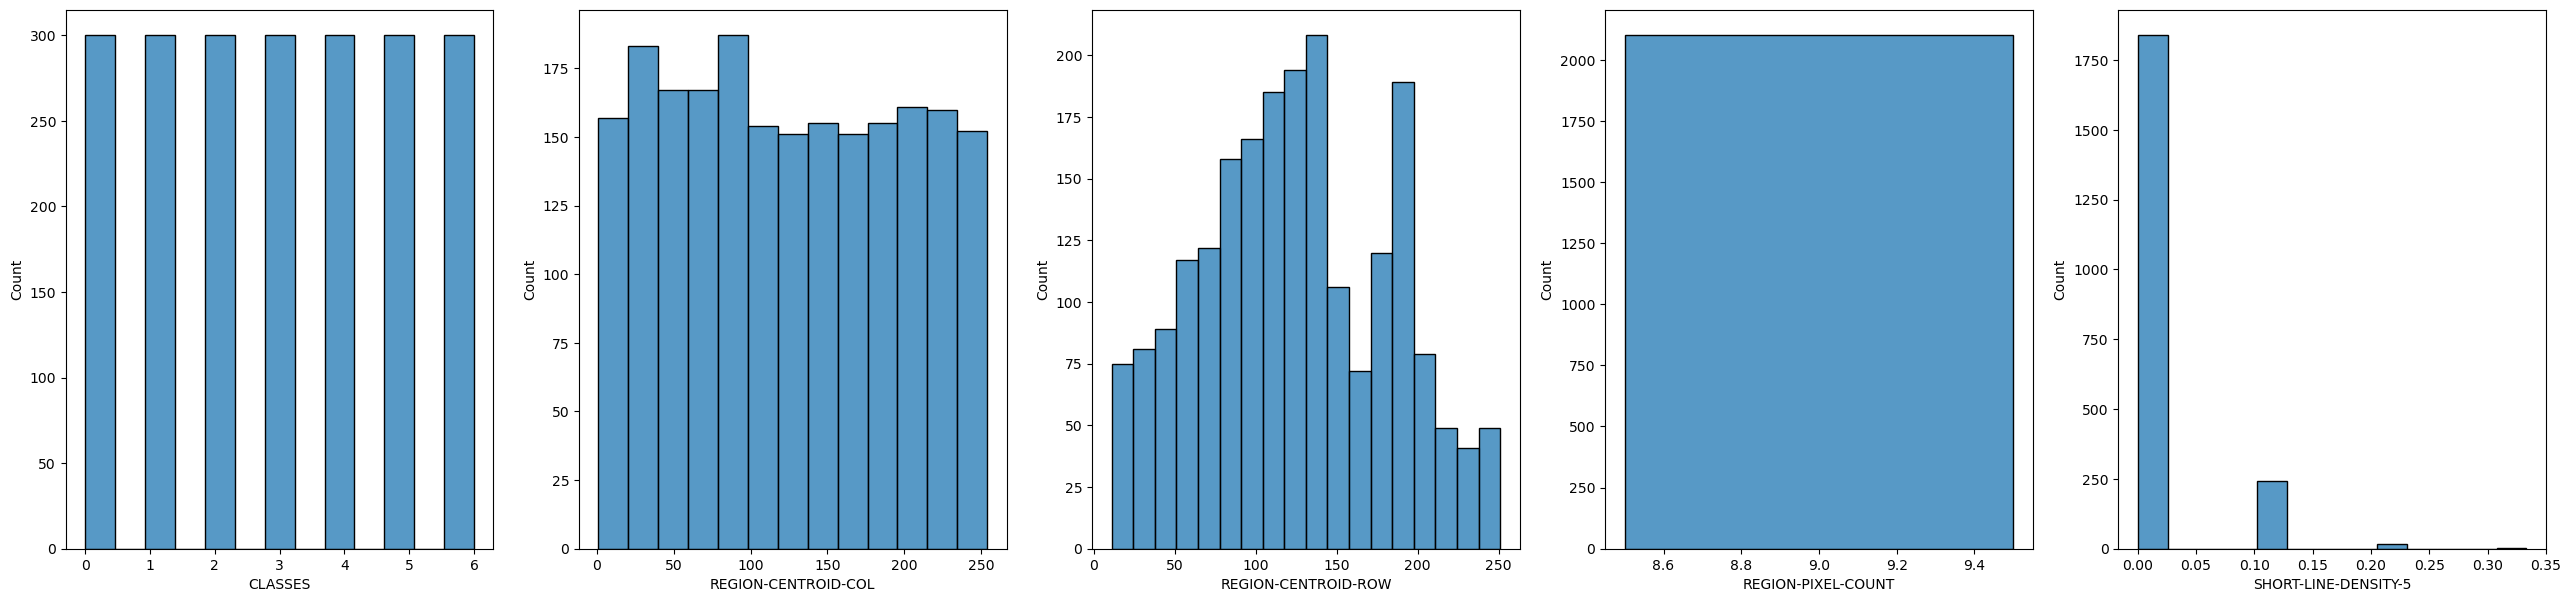

In [159]:
%matplotlib inline
f,axes=plt.subplots(1,5,figsize=(32,7))

sns.histplot(data_train[names[0]],ax=axes[0])
sns.histplot(data_train[names[1]],ax=axes[1])
sns.histplot(data_train[names[2]],ax=axes[2])
sns.histplot(data_train[names[3]],ax=axes[3])
sns.histplot(data_train[names[4]],ax=axes[4])



In [161]:
# La etiqueta CLASSES se distribuye uniformemente, esto ayudará en el entrenamiento.
# igual mente REGION CENTROID COL y PIXEL COUNT
# REGION CENTROID COL tiene una distribución en 140 (MODA TENDENCIAL CENTRAL) y SHORT LINE DENSITY es asimétrica segada hacia la isquierda.

<Axes: xlabel='HEDGE-SD', ylabel='Count'>

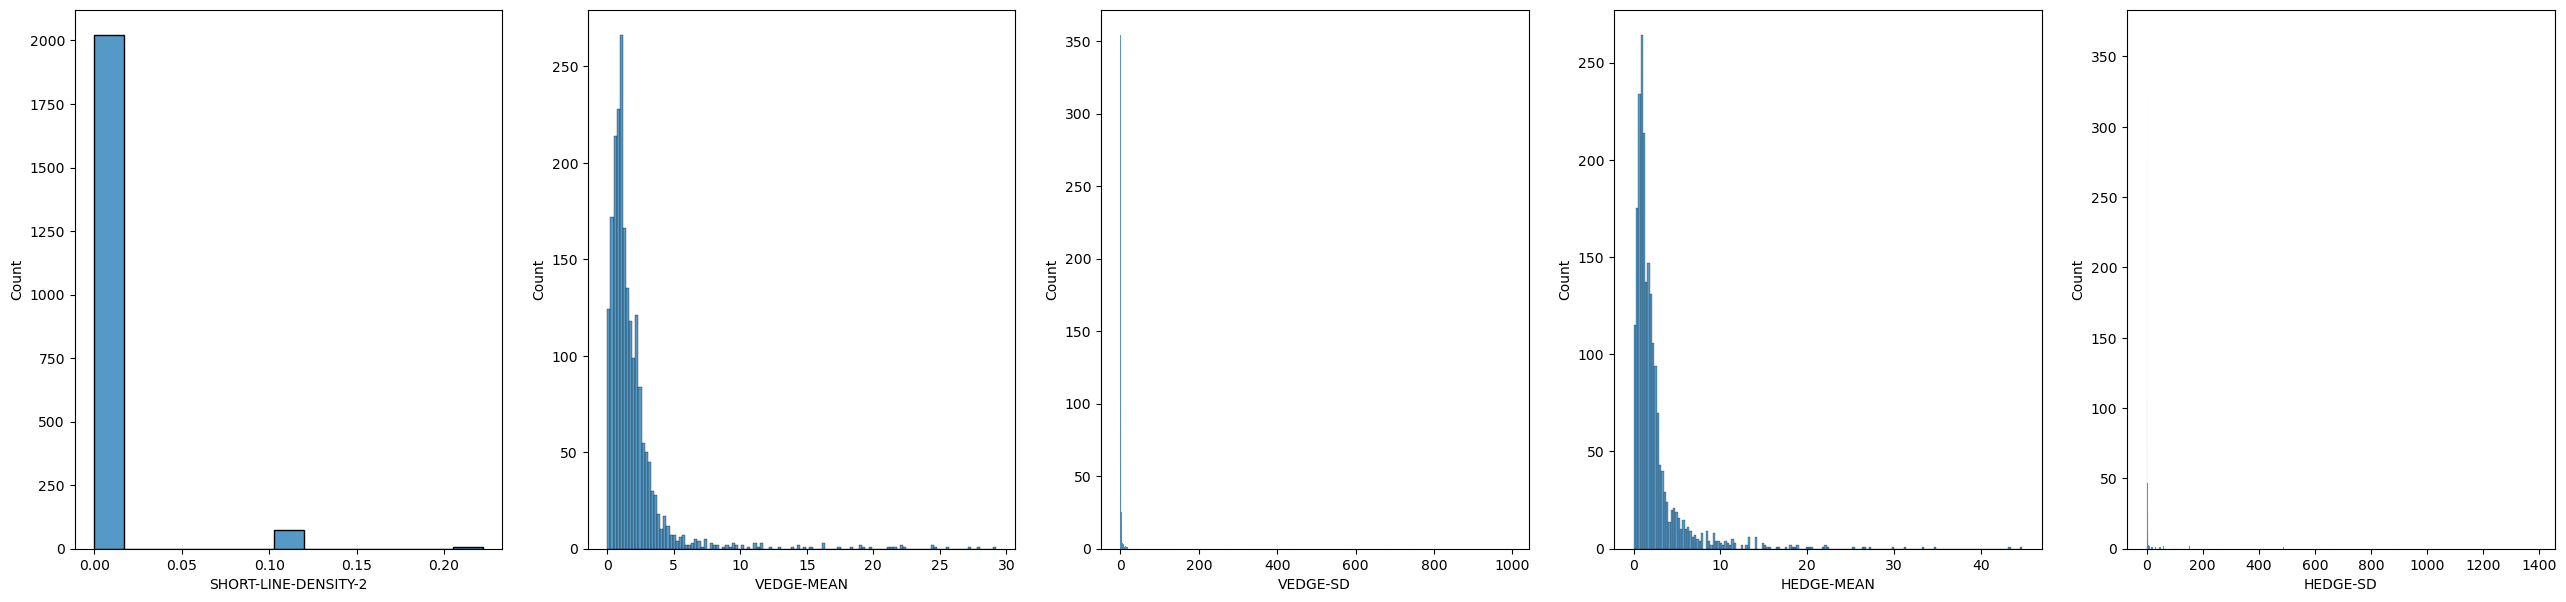

In [148]:
f,axes=plt.subplots(1,5,figsize=(32,7))

sns.histplot(data_train[names[5]],ax=axes[0])
sns.histplot(data_train[names[6]],ax=axes[1])
sns.histplot(data_train[names[7]],ax=axes[2])
sns.histplot(data_train[names[8]],ax=axes[3])
sns.histplot(data_train[names[9]],ax=axes[4])



In [162]:
# La etiqueta SHORT LINE DENSITY 2 , VEDGE MEAN, VEDGE SD, HEDGE MEAN y HEDGE SD son asimétrica y sesgada hacia la izquierda

<Axes: xlabel='EXRED-MEAN', ylabel='Count'>

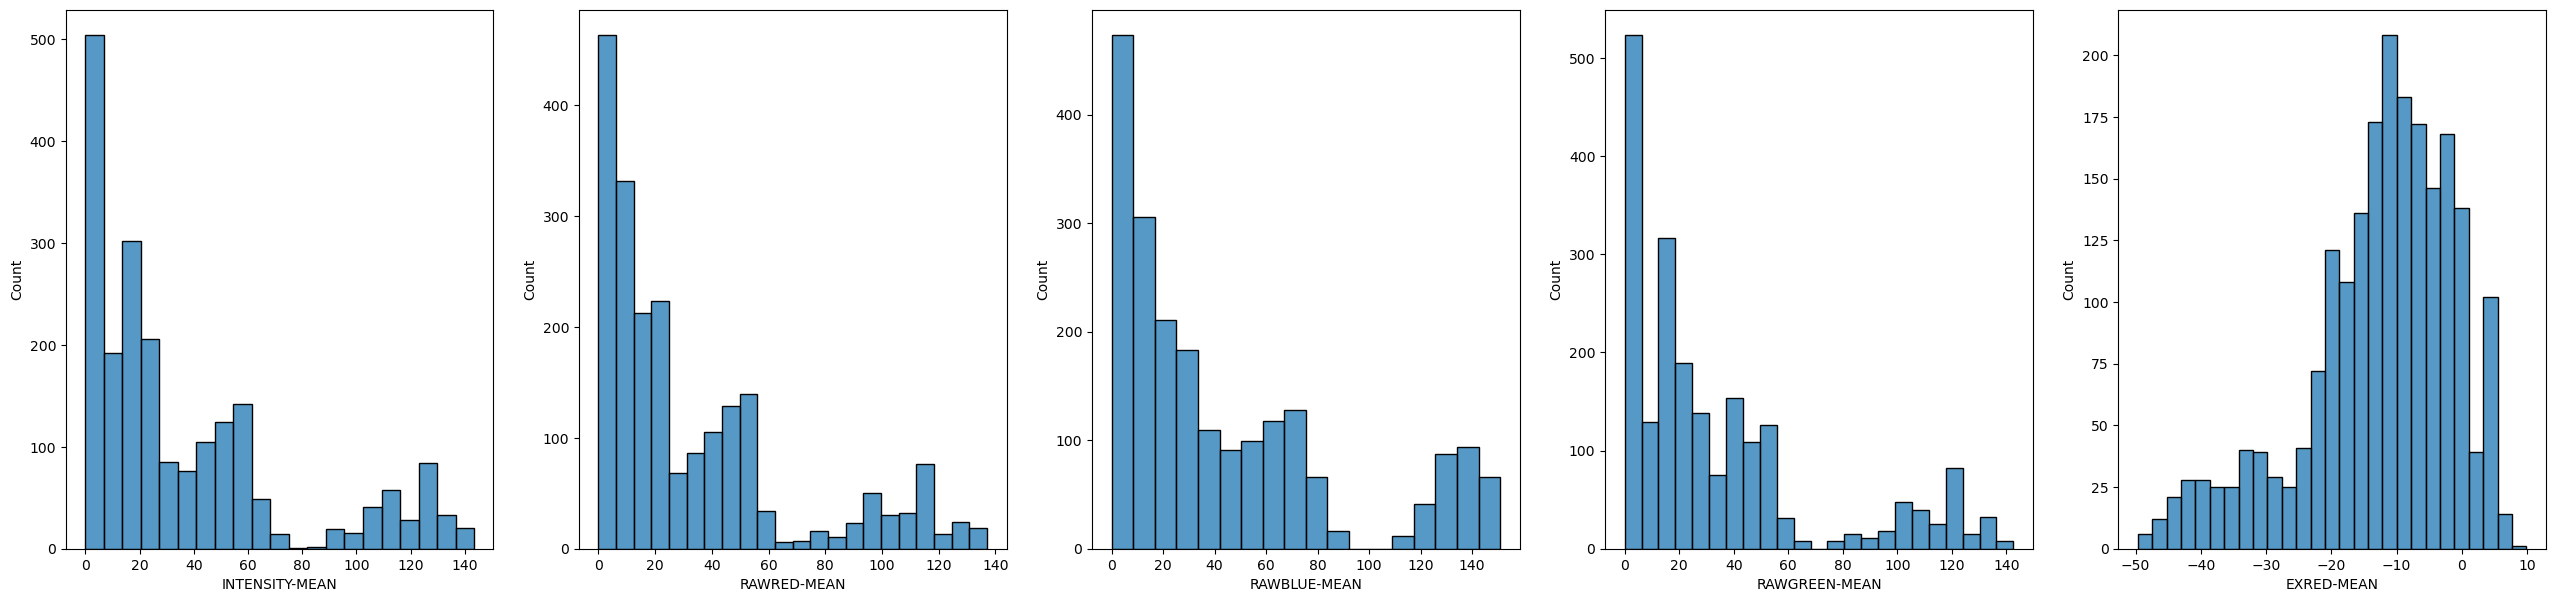

In [163]:
f,axes=plt.subplots(1,5,figsize=(32,7))

sns.histplot(data_train[names[10]],ax=axes[0])
sns.histplot(data_train[names[11]],ax=axes[1])
sns.histplot(data_train[names[12]],ax=axes[2])
sns.histplot(data_train[names[13]],ax=axes[3])
sns.histplot(data_train[names[14]],ax=axes[4])



In [164]:
# La etiqueta INTENSITY MEAN ,RARED MEAN, RAWBLUE MEAN,RAWGREEN son asimétrica y sesgada hacia la izquierda
# Ambas presentan multiplicos
# La etiqueta EXRED_MEAN es asimétrica y sesgada hacia la derecha

<Axes: xlabel='HUE-MEAN', ylabel='Count'>

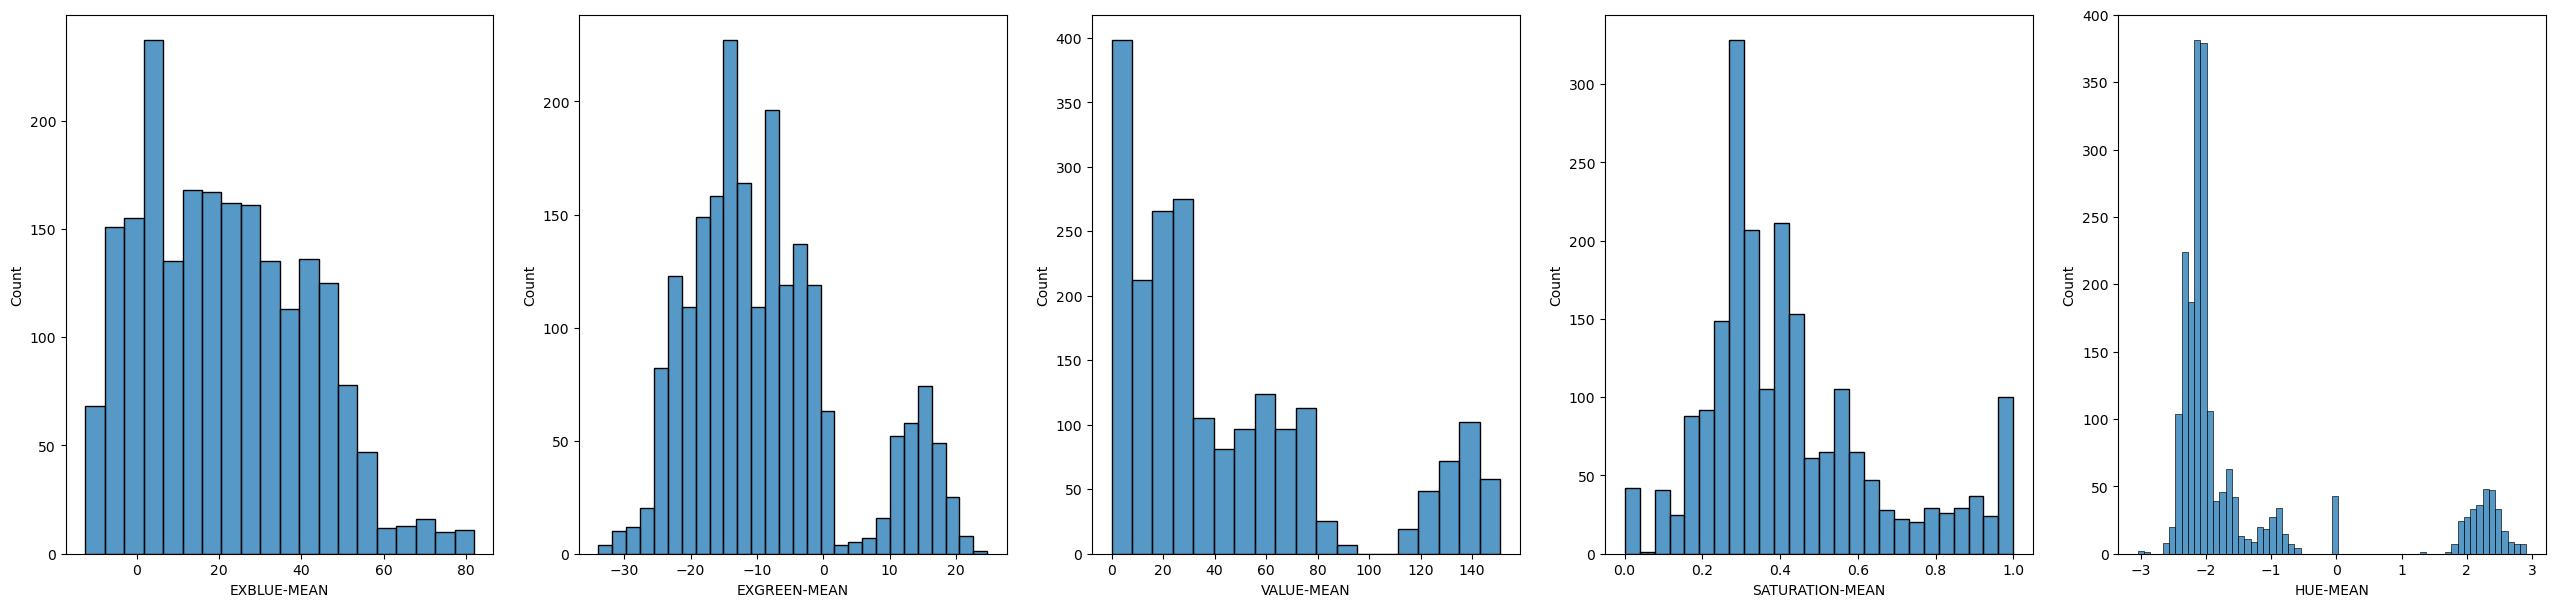

In [150]:
f,axes=plt.subplots(1,5,figsize=(32,7))

sns.histplot(data_train[names[15]],ax=axes[0])
sns.histplot(data_train[names[16]],ax=axes[1])
sns.histplot(data_train[names[17]],ax=axes[2])
sns.histplot(data_train[names[18]],ax=axes[3])
sns.histplot(data_train[names[19]],ax=axes[4])

In [166]:
# La etiqueta EXBLUE MEAN  tiene un sesgo hacia la izquierda pero presenta una tendencia central a valores cercanos a 5

# EXGREEN MEAN presenta una distribución con tendencia modal en -15 y anomalias entre 0 y 10

# VALUE MEAN presenta sego hacia la izquierda

# SATURACION MEAN presenta una distribución con tendencia modal en 0.3 y anomalias entre 0.8 y 0.1

# HUE MEAN presenta una distribución con tendencia modal en -2 y anomalias entre -1 y 3

### Matriz de correlación de Pearson

$\rho_{XY} = \frac{Cov(XY)}{\sqrt{Var(x)Var(y)}}$

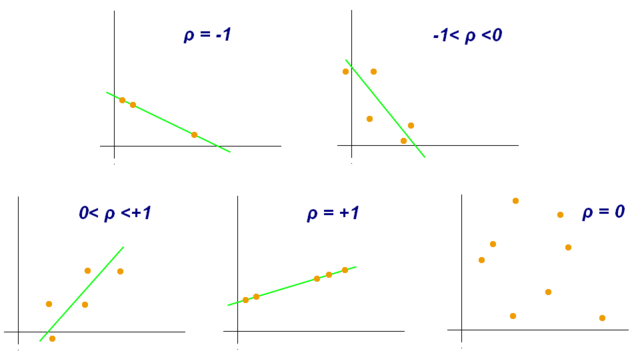

In [151]:
pd.set_option('display.width',100)
data_train.corr(method='pearson')
#variables linealmente independientes
#[x1,x2,x3,x4] -> [y]
#(xi no debe depender de xj)

CLASSES  REGION-CENTROID-COL  REGION-CENTROID-ROW  REGION-PIXEL-COUNT  \
CLASSES               1.000000            -0.179889            -0.732779                 NaN   
REGION-CENTROID-COL  -0.179889             1.000000             0.021115                 NaN   
REGION-CENTROID-ROW  -0.732779             0.021115             1.000000                 NaN   
REGION-PIXEL-COUNT         NaN                  NaN                  NaN                 NaN   
SHORT-LINE-DENSITY-5 -0.020641            -0.048088             0.057781                 NaN   
SHORT-LINE-DENSITY-2 -0.039288            -0.003448             0.044630                 NaN   
VEDGE-MEAN           -0.073797            -0.003043             0.027878                 NaN   
VEDGE-SD              0.031728             0.032893            -0.053462                 NaN   
HEDGE-MEAN           -0.141337            -0.010776             0.115810                 NaN   
HEDGE-SD              0.001015             0.010001            -0.018819                 NaN   
INTENSITY-MEAN        0.252620             0.063692            -0.464687                 NaN   
RAWRED-MEAN           0.269834             0.059320            -0.467181                 NaN   
RAWBLUE-MEAN          0.266674             0.062584            -0.481601                 NaN   
RAWGREEN-MEAN         0.216380             0.068527            -0.436859                 NaN   
EXRED-MEAN           -0.049446            -0.091395             0.355238                 NaN   
EXBLUE-MEAN           0.300594             0.044899            -0.493568                 NaN   
EXGREEN-MEAN         -0.459630             0.015220             0.481096                 NaN   
VALUE-MEAN            0.240094             0.064662            -0.458177                 NaN   
SATURATION-MEAN       0.093929            -0.107226             0.083261                 NaN   
HUE-MEAN             -0.535901             0.038136             0.592500                 NaN   

                      SHORT-LINE-DENSITY-5  SHORT-LINE-DENSITY-2  VEDGE-MEAN  VEDGE-SD  \
CLASSES                          -0.020641             -0.039288   -0.073797  0.031728   
REGION-CENTROID-COL              -0.048088             -0.003448   -0.003043  0.032893   
REGION-CENTROID-ROW               0.057781              0.044630    0.027878 -0.053462   
REGION-PIXEL-COUNT                     NaN                   NaN         NaN       NaN   
SHORT-LINE-DENSITY-5              1.000000             -0.021583   -0.019855 -0.033317   
SHORT-LINE-DENSITY-2             -0.021583              1.000000    0.245888  0.190272   
VEDGE-MEAN                       -0.019855              0.245888    1.000000  0.645167   
VEDGE-SD                         -0.033317              0.190272    0.645167  1.000000   
HEDGE-MEAN                       -0.021006              0.286555    0.542281  0.455123   
HEDGE-SD                         -0.040218              0.245607    0.487143  0.681719   
INTENSITY-MEAN                   -0.019914             -0.017532   -0.000577 -0.000062   
RAWRED-MEAN                      -0.018077             -0.022947   -0.011085 -0.004933   
RAWBLUE-MEAN                     -0.022782             -0.008058    0.014921  0.003661   
RAWGREEN-MEAN                    -0.018028             -0.023472   -0.009016  0.000172   
EXRED-MEAN                        0.032835             -0.034804   -0.094727 -0.044078   
EXBLUE-MEAN                      -0.035382              0.048537    0.102454  0.024676   
EXGREEN-MEAN                      0.027130             -0.047441   -0.078911  0.002223   
VALUE-MEAN                       -0.017559             -0.011304    0.012533  0.001622   
SATURATION-MEAN                  -0.042157              0.029233   -0.061904  0.003691   
HUE-MEAN                          0.105853             -0.079683   -0.096855 -0.061239   

                      HEDGE-MEAN  HEDGE-SD  INTENSITY-MEAN  RAWRED-MEAN  RAWBLUE-MEAN  \
CLASSES                -0.

In [168]:
# Lo valores no presentan una alta correlación entre ellas excepto 
# VALUE MEAN con RAWBLUE MEAN RAW_RED , EXBLUE, esto se entiende porque son valores promedio que componen a VALUE MEAN

<Figure size 640x480 with 0 Axes>

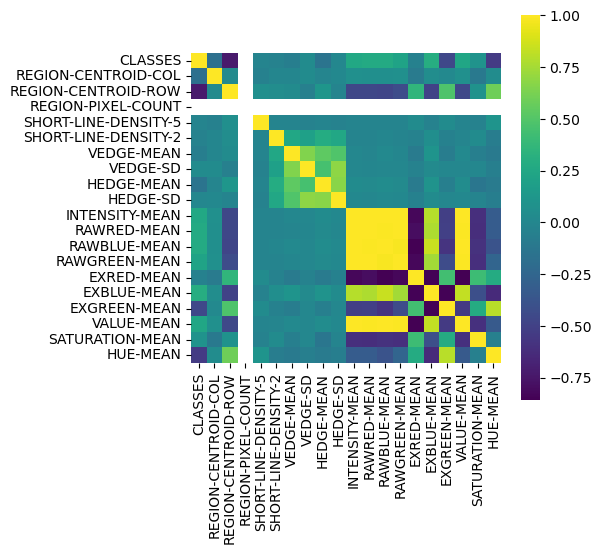

In [174]:
#Mapa de calor
fig=plt.figure()
correlation=data_train.corr(method='pearson')
plt.figure(figsize=(5,5))
ax=sns.heatmap(correlation,vmax=1,square=True,annot=False,cmap='viridis')#tmb se puede usar matplotlib pero son mas lineas

In [179]:
# LA MATRIZ de correlación nos permite ver los valores que se correlacionan entre sí, Vemos 3 grupos grandes:
# -> entre [VEDGE-MEAN - HEDGE SD]!
# -> entre [INTENSITY-MEAN - RAWGREEN-MEAN]!
# -> [INTENSITY-MEAN - RAWGREEN-MEAN] -> VALUE MEAN


In [180]:
names

Index(['CLASSES', 'REGION-CENTROID-COL', 'REGION-CENTROID-ROW', 'REGION-PIXEL-COUNT',
       'SHORT-LINE-DENSITY-5', 'SHORT-LINE-DENSITY-2', 'VEDGE-MEAN', 'VEDGE-SD', 'HEDGE-MEAN',
       'HEDGE-SD', 'INTENSITY-MEAN', 'RAWRED-MEAN', 'RAWBLUE-MEAN', 'RAWGREEN-MEAN', 'EXRED-MEAN',
       'EXBLUE-MEAN', 'EXGREEN-MEAN', 'VALUE-MEAN', 'SATURATION-MEAN', 'HUE-MEAN'],
      dtype='object')

<Axes: xlabel='RAWRED-MEAN', ylabel='RAWGREEN-MEAN'>

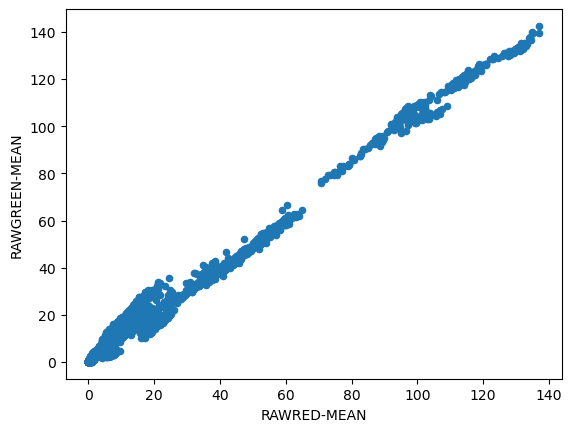

In [185]:
data_train.plot(kind="scatter",x="RAWRED-MEAN",y="RAWGREEN-MEAN") #existe correlación lineal

<Axes: xlabel='REGION-PIXEL-COUNT', ylabel='HUE-MEAN'>

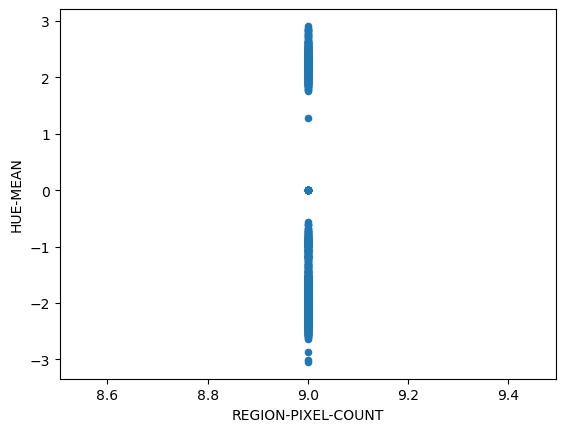

In [186]:
data_train.plot(kind="scatter",x="REGION-PIXEL-COUNT",y="HUE-MEAN") #no existe correlación lineal es un buen indicador

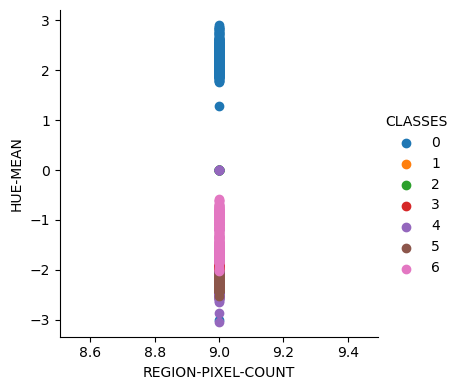

In [188]:
#Lo ideal seria azules izq, narajas en centro y verdes derecha
#Justificar la seleccion de atributos

g=sns.FacetGrid(data_train,height=4,hue="CLASSES") #"class" - nombre de la clase o el target
g.map(plt.scatter,"REGION-PIXEL-COUNT","HUE-MEAN")
g.add_legend()

In [ ]:
#Los valores son de 9 pixel, es una variable que no posee diversidas de dominio, entonces se descartará

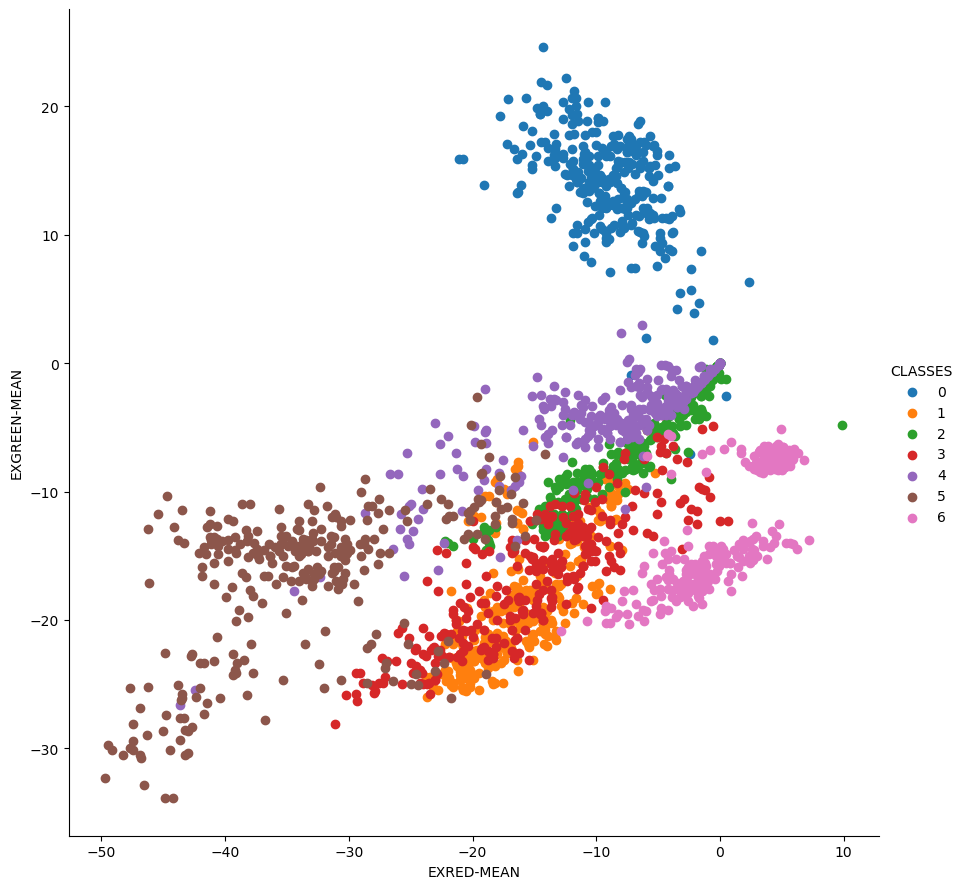

In [405]:
g=sns.FacetGrid(data_train,height=9,hue="CLASSES") #"class" - nombre de la clase o el target
g.map(plt.scatter,"EXRED-MEAN","EXGREEN-MEAN")
g.add_legend()

In [201]:
#Presenta buenos valores segmentados

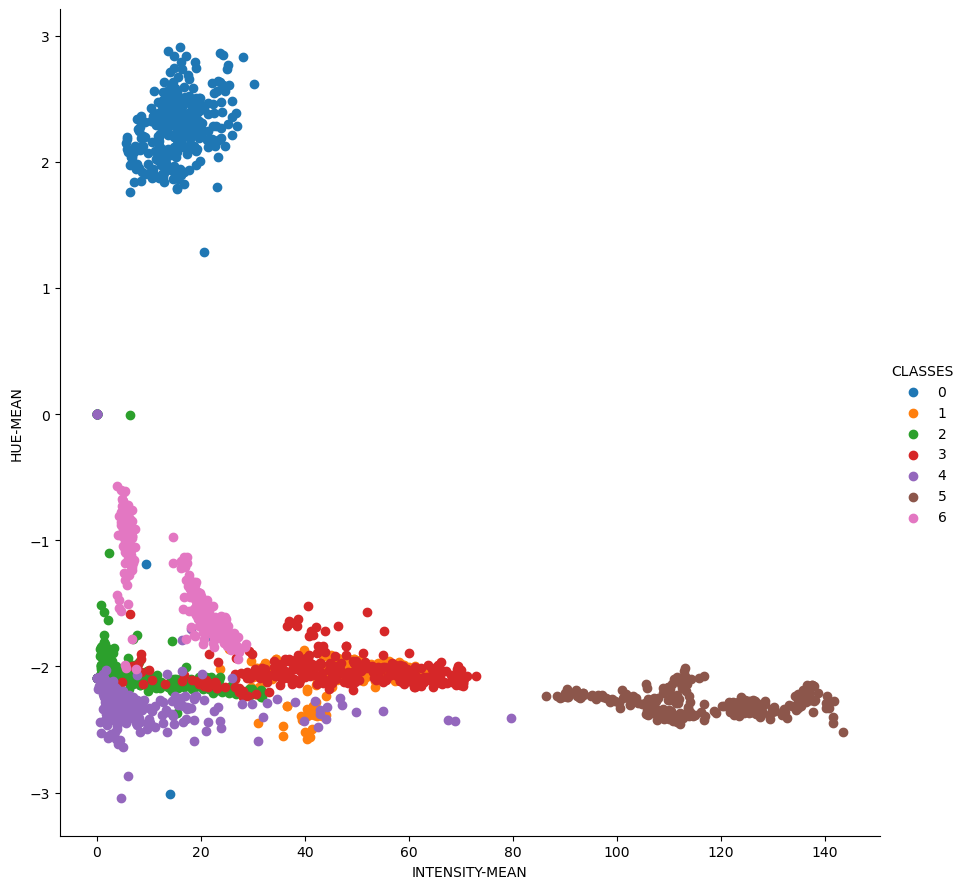

In [406]:
g=sns.FacetGrid(data_train,height=9,hue="CLASSES") #"class" - nombre de la clase o el target
g.map(plt.scatter,"INTENSITY-MEAN","HUE-MEAN")
g.add_legend()

In [202]:
#Hay algunos valores atípicos en la clase 0 y 4 

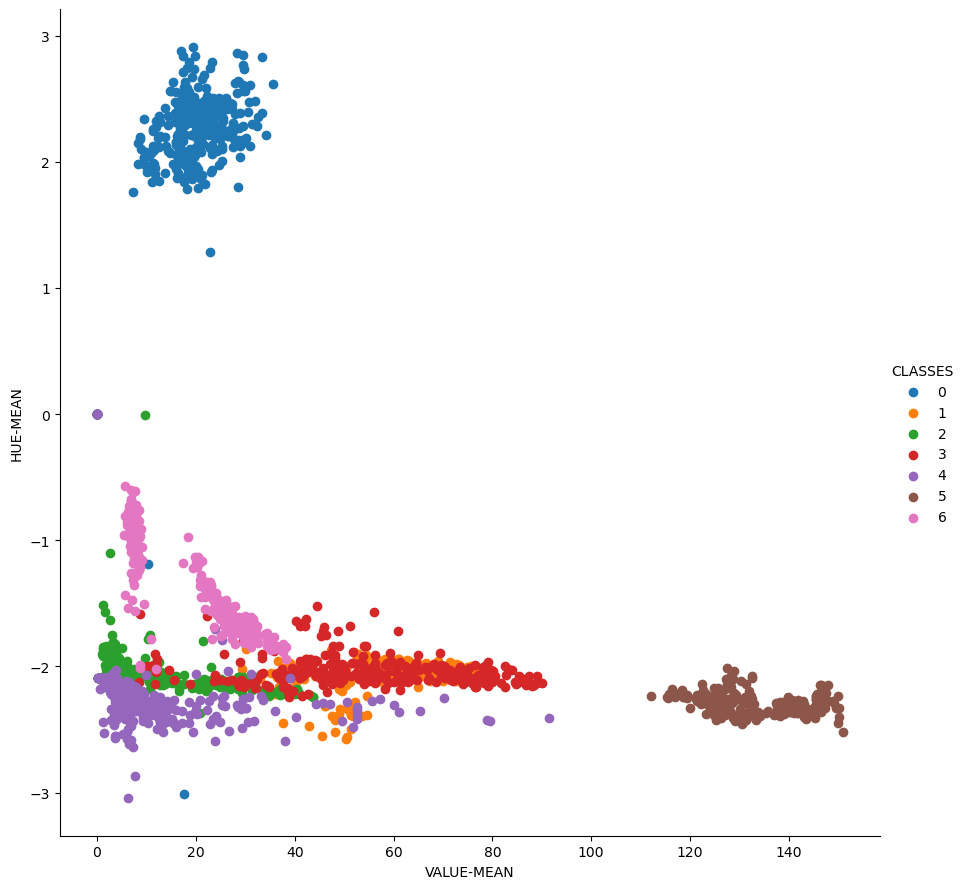

In [407]:
g=sns.FacetGrid(data_train,height=9,hue="CLASSES") #"class" - nombre de la clase o el target
g.map(plt.scatter,"VALUE-MEAN","HUE-MEAN")
g.add_legend()

In [203]:
#Hay algunos valores atípicos en la clase 0 y 4 y es parecida a la anterior relación

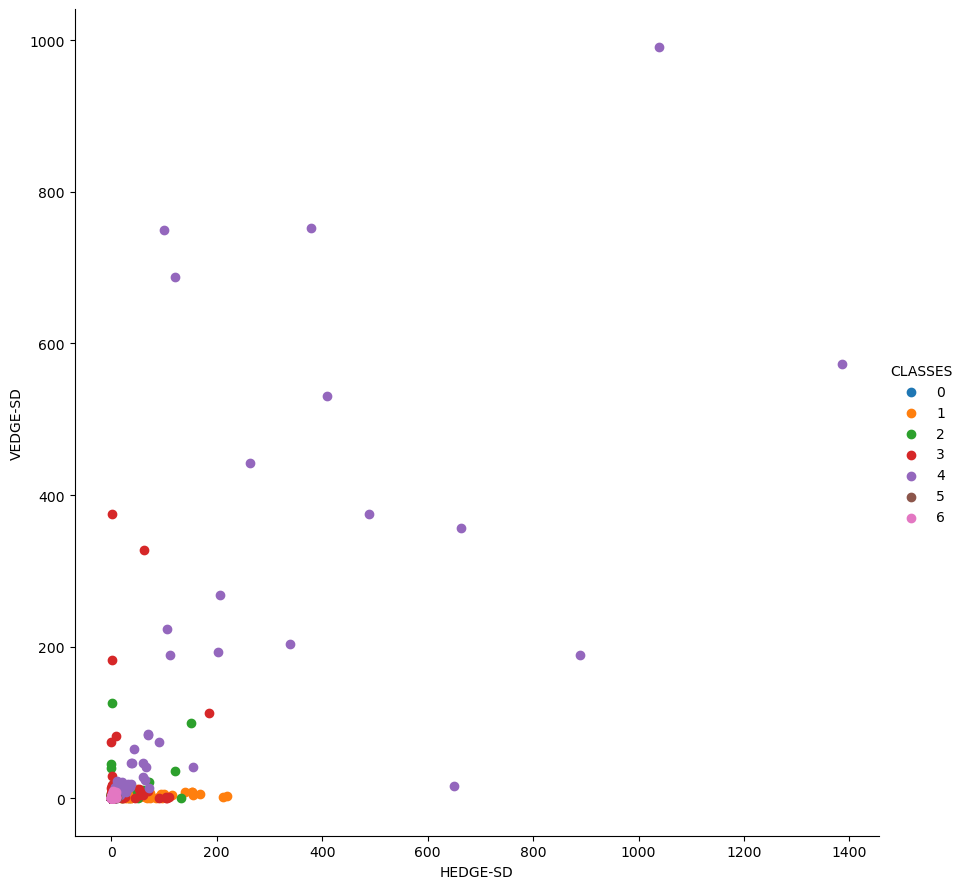

In [408]:
g=sns.FacetGrid(data_train,height=9,hue="CLASSES") #"class" - nombre de la clase o el target
g.map(plt.scatter,"HEDGE-SD","VEDGE-SD")
g.add_legend()

In [204]:
#Es difícil de observar los límites de cada clase para su segmentación

C:\Users\Admin\anaconda3\lib\site-packages\seaborn\axisgrid.py:848: UserWarning: You passed a edgecolor/edgecolors ('gray') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  func(*plot_args, **plot_kwargs)


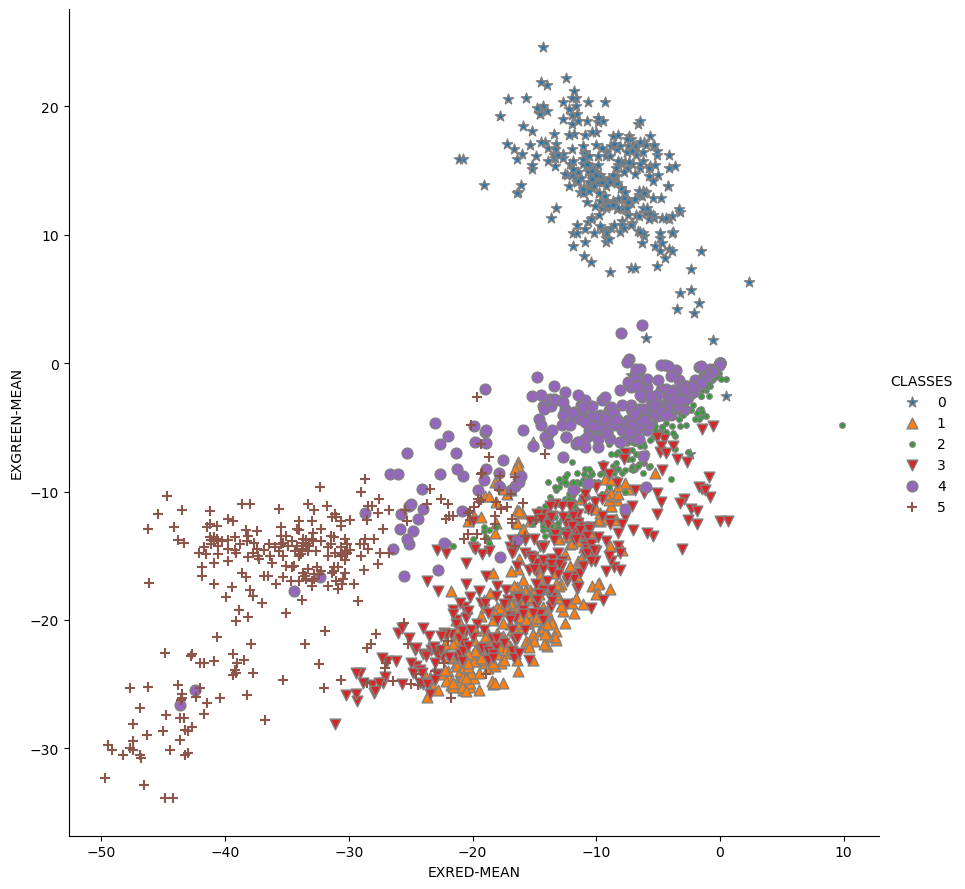

In [409]:
#Lo ideal seria azules izq, narajas en centro y verdes derecha
#FacetGrid -> opcion de personalizar para cambiar colores y formas

g=sns.FacetGrid(data_train,height=9,hue="CLASSES",hue_order=[i for i in range(0,6)],
                                hue_kws=dict(marker=["*", "^", ".", "v", "o", "+"])) #"class" - nombre de la clase o el target
g.map(plt.scatter,"EXRED-MEAN","EXGREEN-MEAN",s=60,edgecolor="gray")
g.add_legend()

In [223]:
data_train[names[5:10]]

SHORT-LINE-DENSITY-2  VEDGE-MEAN  VEDGE-SD  HEDGE-MEAN  HEDGE-SD
0                      0.0    1.000000  0.666667    1.222222  1.186342
1                      0.0    1.111111  0.720082    1.444444  0.750309
2                      0.0    3.388889  2.195113    3.000000  1.520234
3                      0.0    1.277778  1.254621    1.000000  0.894427
4                      0.0    1.166667  0.691215    1.166667  1.005540
...                    ...         ...       ...         ...       ...
2095                   0.0    0.944445  0.862963    0.833333  0.611111
2096                   0.0    1.611111  2.062962    0.333333  0.133333
2097                   0.0    0.555555  0.251852    0.777778  0.162963
2098                   0.0    2.166667  1.633334    1.388889  0.418518
2099                   0.0    1.388889  1.129630    2.000000  0.888889

[2100 rows x 5 columns]

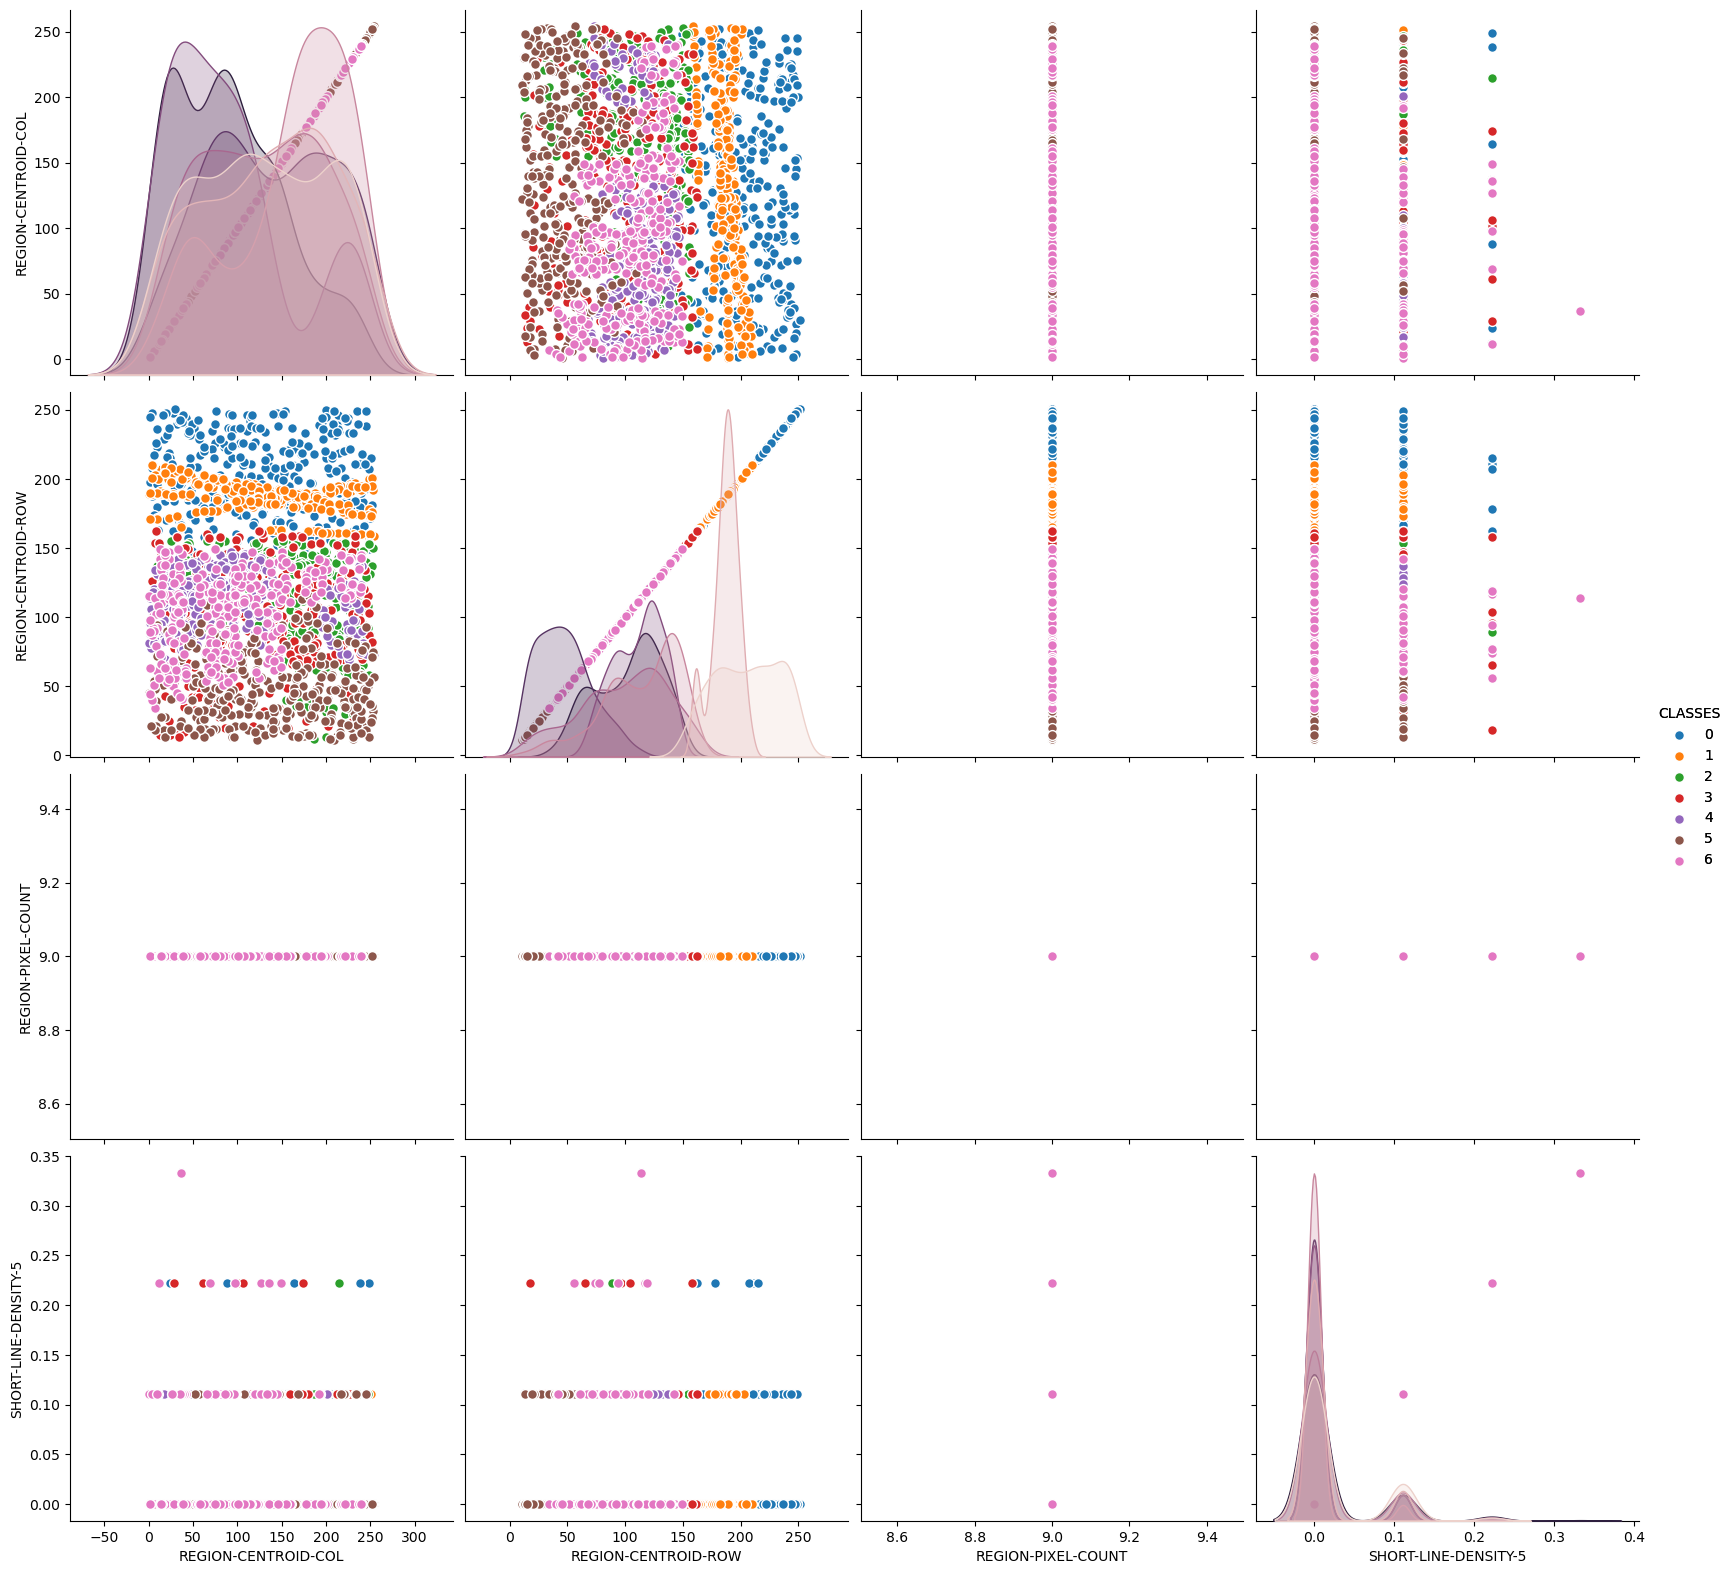

In [222]:
#muestra sesgo, solapamiento,
g=sns.pairplot(data_train[names[0:5]],hue='CLASSES',height=4)
g.map(plt.scatter,s=50,edgecolor="white")
g.add_legend()

In [234]:
names[6:10]

Index(['VEDGE-MEAN', 'VEDGE-SD', 'HEDGE-MEAN', 'HEDGE-SD'], dtype='object')

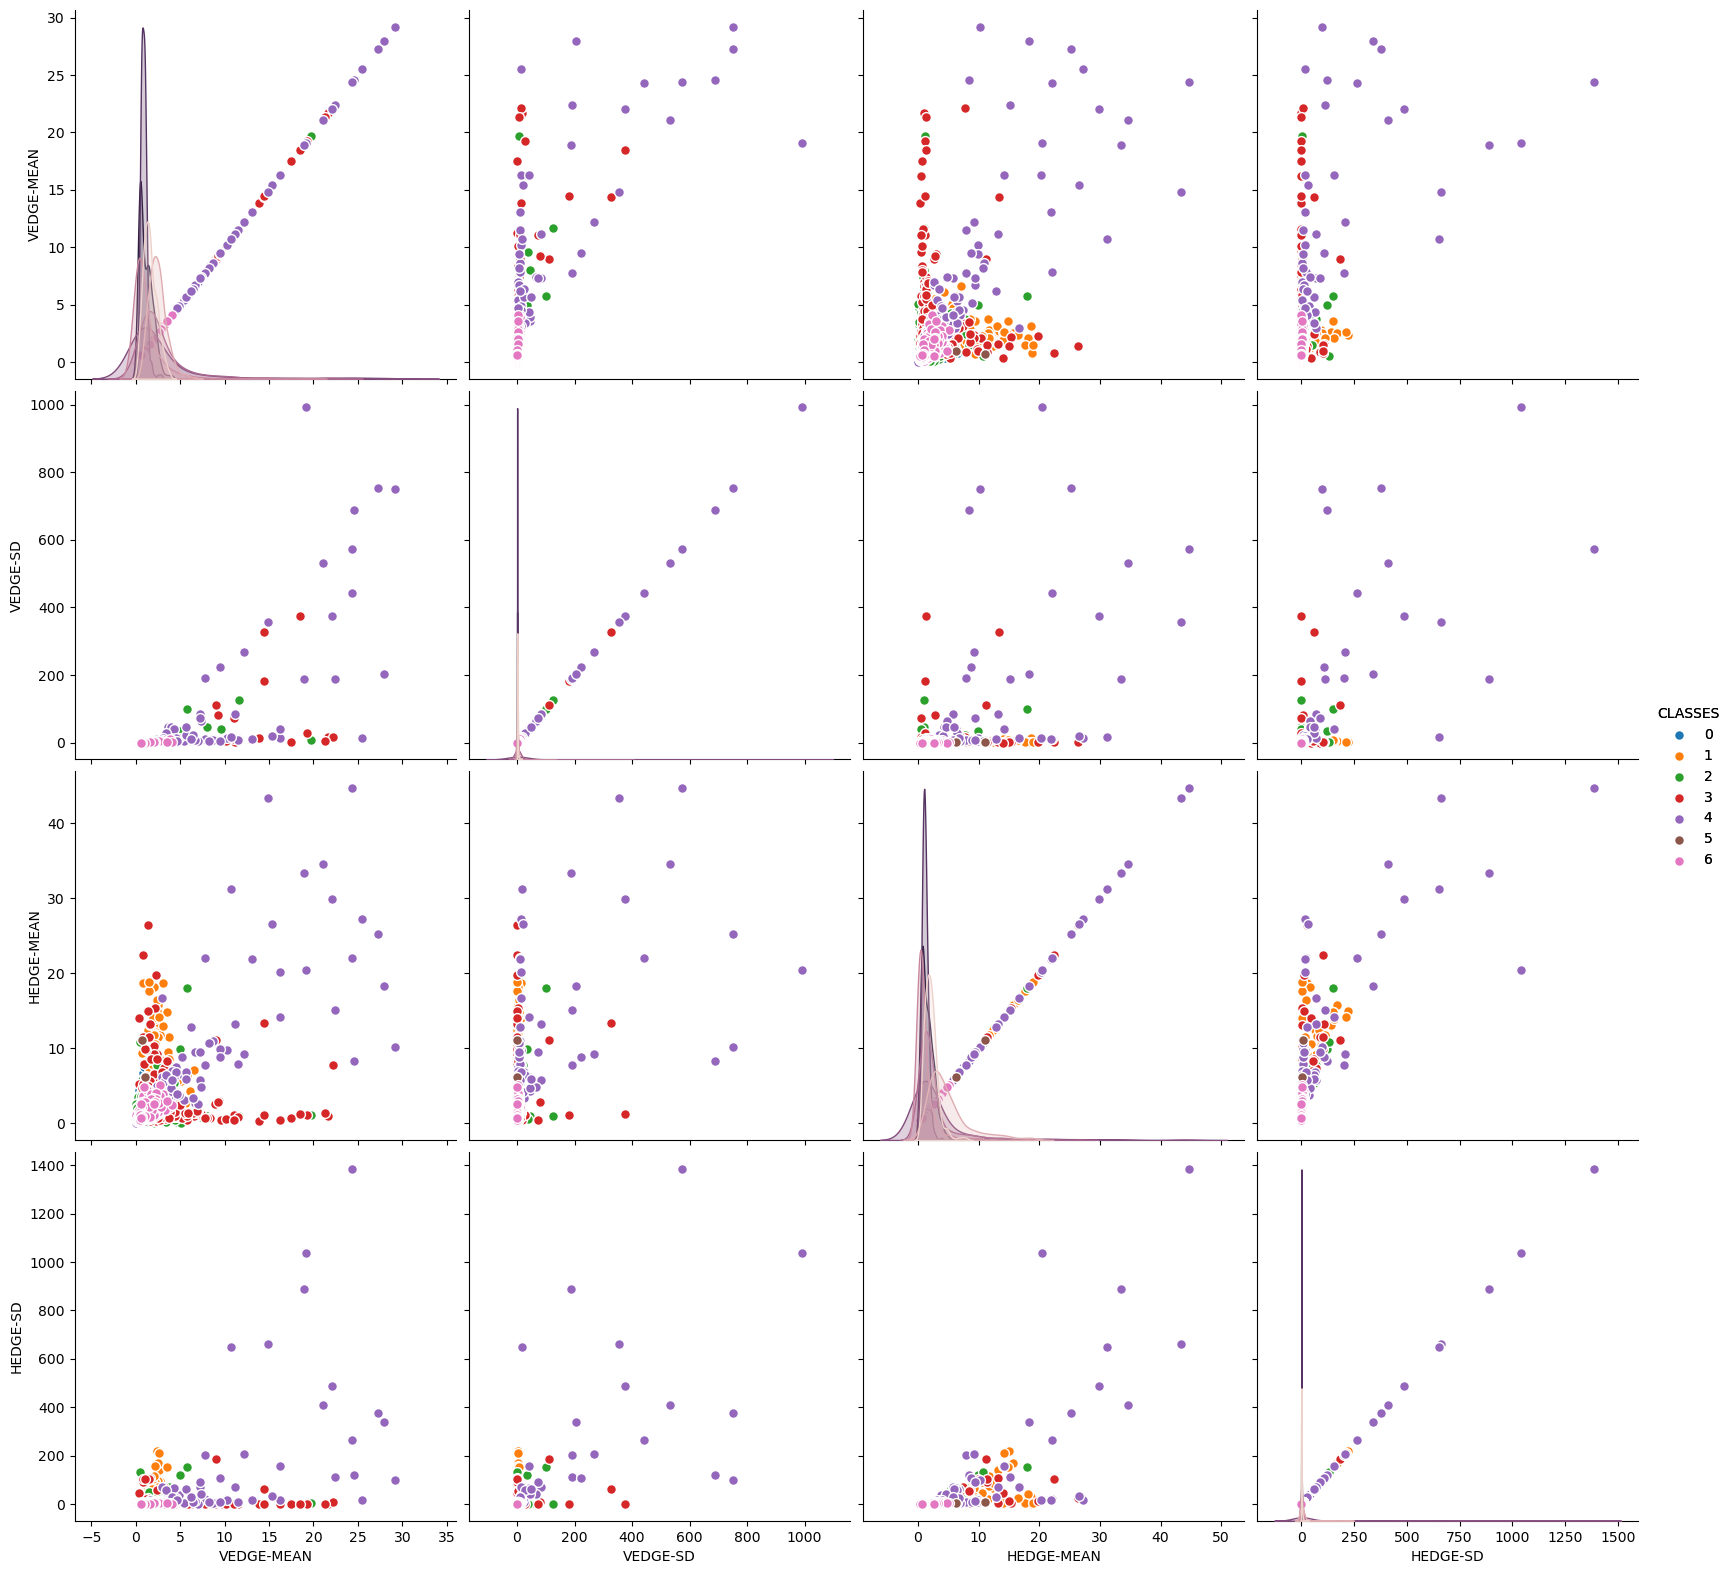

In [235]:
#muestra sesgo, solapamiento,
g=sns.pairplot(data_train[ [ 'CLASSES','VEDGE-MEAN', 'VEDGE-SD', 'HEDGE-MEAN', 'HEDGE-SD']],hue='CLASSES',height=4)
g.map(plt.scatter,s=50,edgecolor="white")
g.add_legend()

In [236]:
names[10:15]

Index(['INTENSITY-MEAN', 'RAWRED-MEAN', 'RAWBLUE-MEAN', 'RAWGREEN-MEAN', 'EXRED-MEAN'], dtype='object')

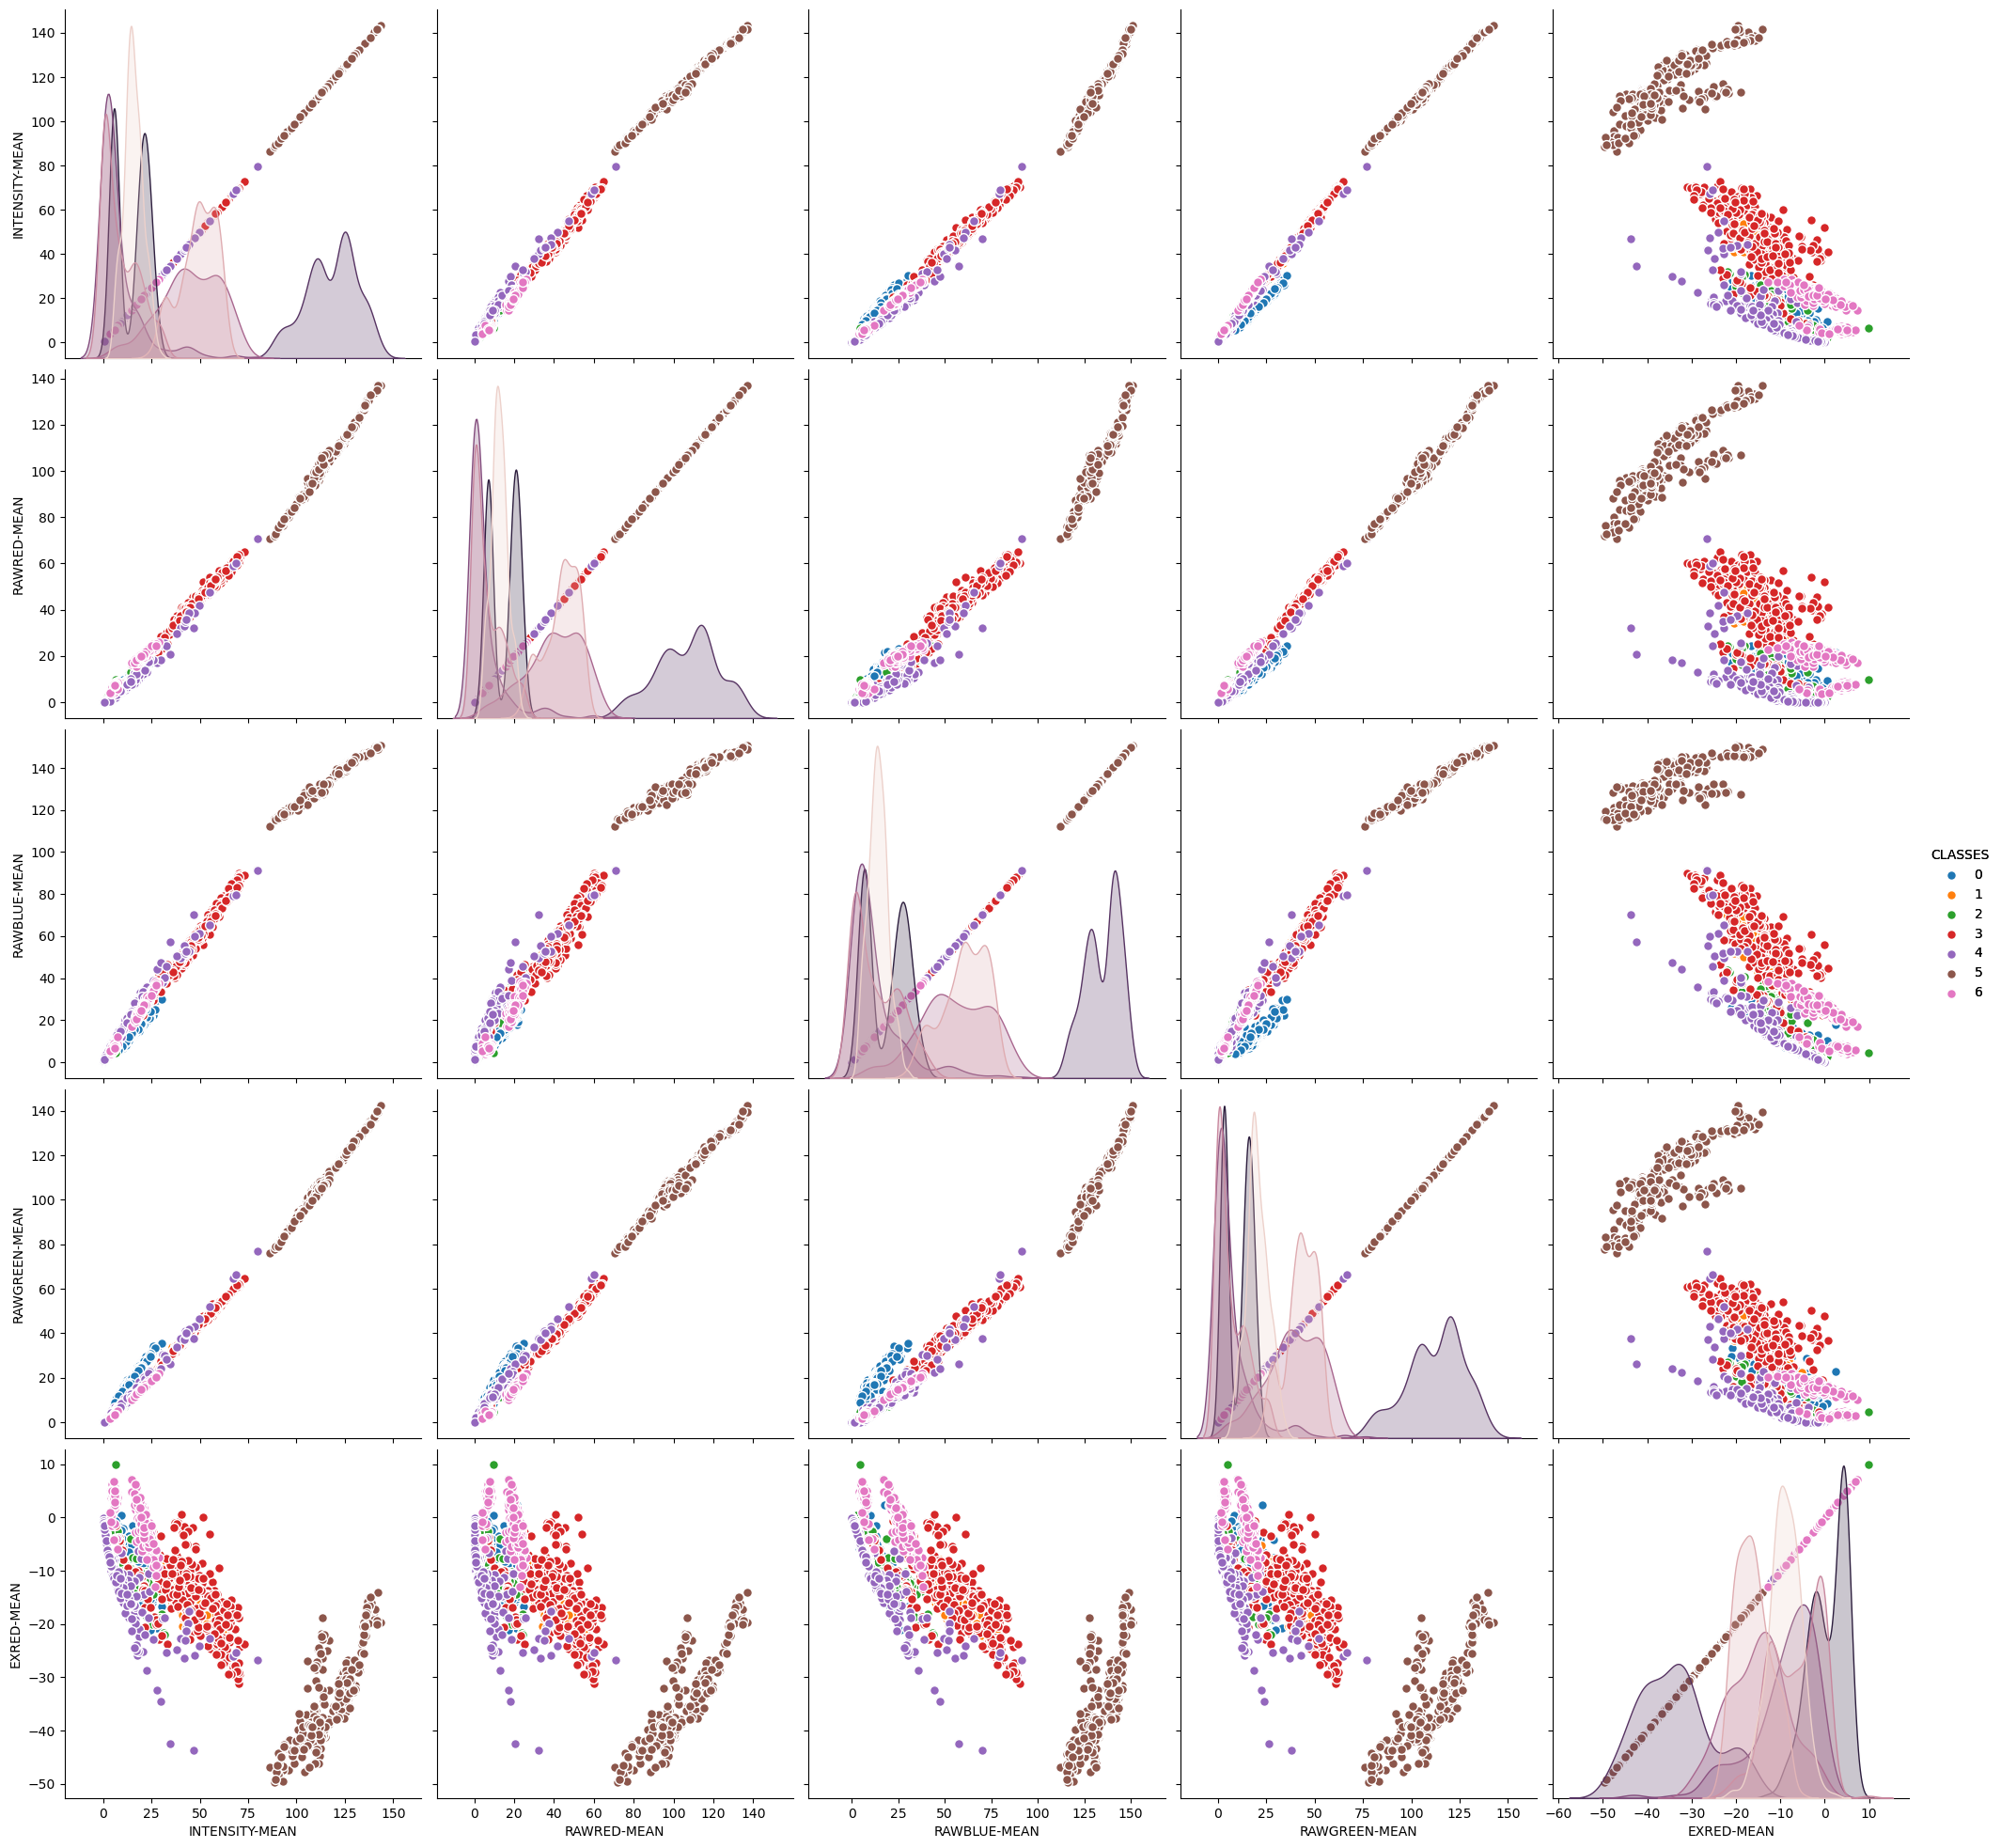

In [237]:
#muestra sesgo, solapamiento,
g=sns.pairplot(data_train[ [ 'CLASSES','INTENSITY-MEAN', 'RAWRED-MEAN', 'RAWBLUE-MEAN', 'RAWGREEN-MEAN', 'EXRED-MEAN']],hue='CLASSES',height=4)
g.map(plt.scatter,s=50,edgecolor="white")
g.add_legend()

In [238]:
names[15:21]

Index(['EXBLUE-MEAN', 'EXGREEN-MEAN', 'VALUE-MEAN', 'SATURATION-MEAN', 'HUE-MEAN'], dtype='object')

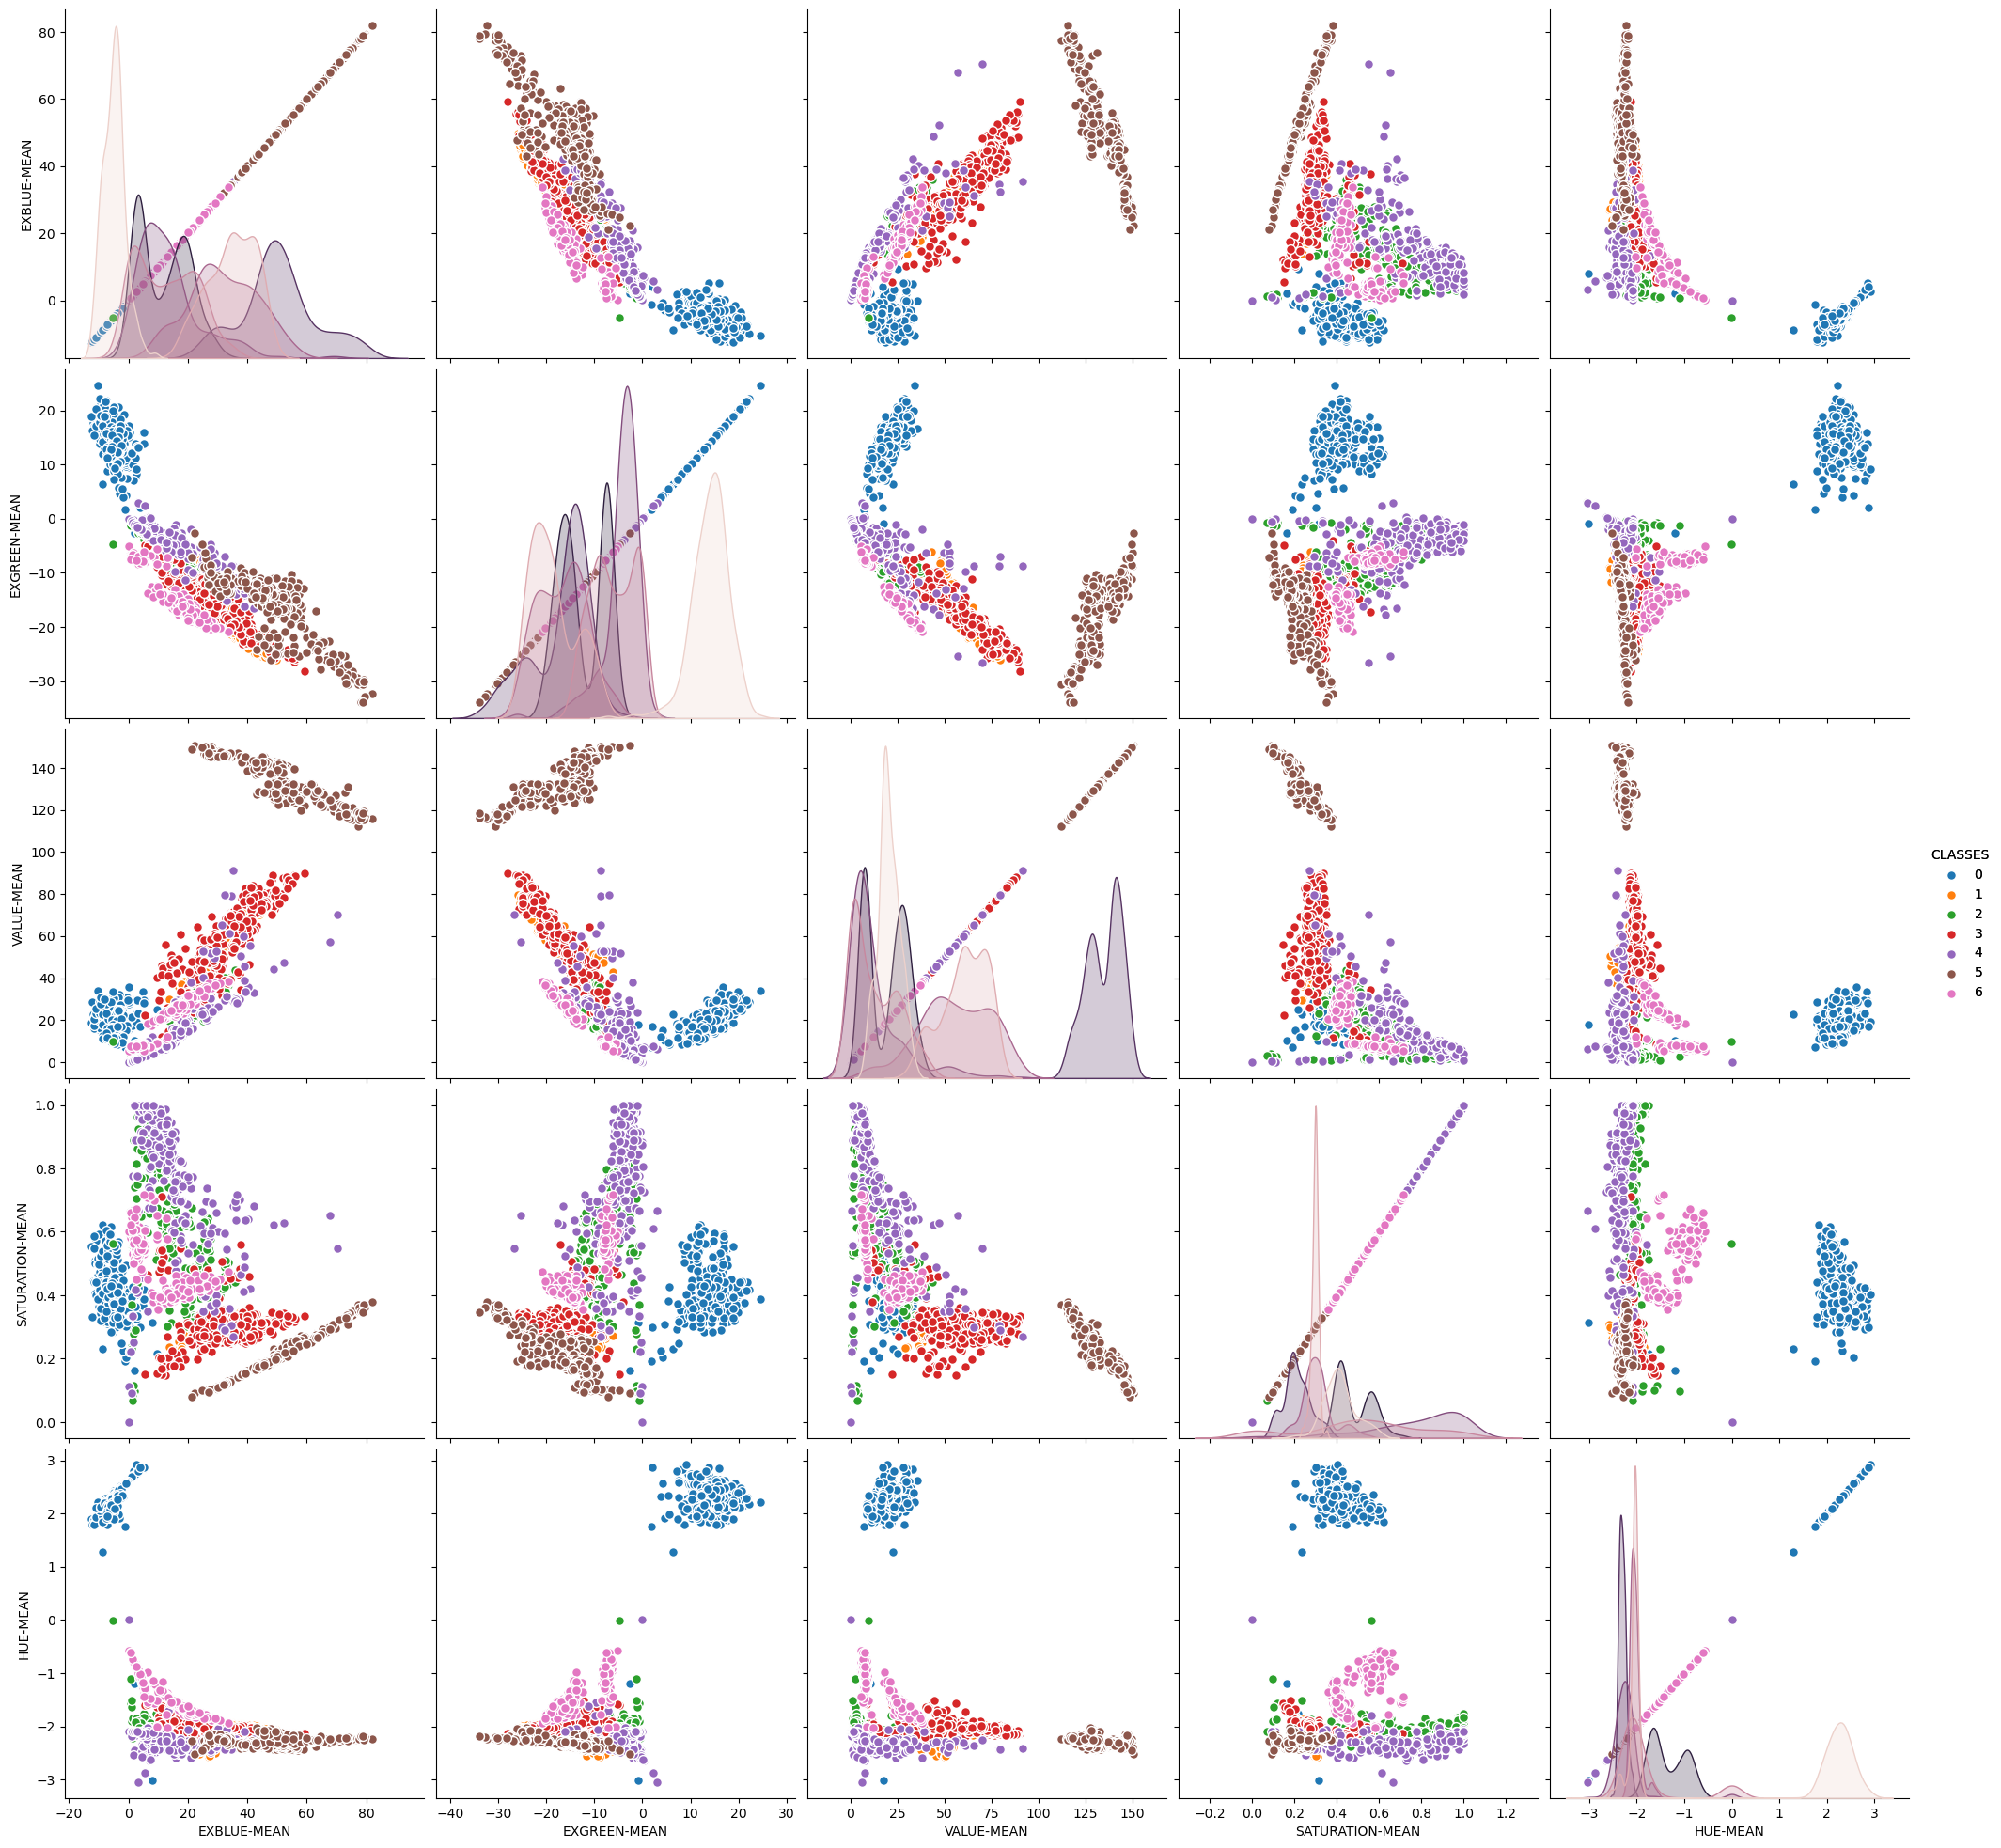

In [239]:
#muestra sesgo, solapamiento,
g=sns.pairplot(data_train[ [ 'CLASSES','EXBLUE-MEAN', 'EXGREEN-MEAN', 'VALUE-MEAN', 'SATURATION-MEAN', 'HUE-MEAN']],hue='CLASSES',height=4)
g.map(plt.scatter,s=50,edgecolor="white")
g.add_legend()

<h2> 1.4. Algunos tratamientos </h2>

In [242]:
array_train = data_train.values  #solo valores
#Separar el input del target
X=array_train[:,1:]
y=array_train[:,0]

In [243]:
#Ahora veremos la forma de cada conjunto:
print('Forma para X',x_train.shape)
print('Forma para y',y_train.shape)

Forma para X (2100, 19)
Forma para y (2100,)


<h3> 1.4.1. Escalamiento </h3>

In [247]:
#TRansformacion de datos
# Escalaremos los datos entre el ango de 0 a 1 para una mejor bsuqueda de optimización reuciendo el sesgo y la varianza

from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler(feature_range=(0,1))
rescaledX=scaler.fit_transform(X)
np.set_printoptions(precision=3)
#Convertimos el Numpy Array a dataframe
transform_df=pd.DataFrame(rescaledX,columns=names[1:])
transform_df.head(10)

REGION-CENTROID-COL  REGION-CENTROID-ROW  REGION-PIXEL-COUNT  SHORT-LINE-DENSITY-5  \
0             0.430830             0.741667                 0.0              0.000000   
1             0.335968             0.733333                 0.0              0.000000   
2             0.885375             0.970833                 0.0              0.000000   
3             0.181818             0.920833                 0.0              0.000000   
4             0.379447             0.729167                 0.0              0.000000   
5             0.616601             0.875000                 0.0              0.000000   
6             0.241107             0.887500                 0.0              0.000000   
7             0.102767             0.987500                 0.0              0.333333   
8             0.169960             0.925000                 0.0              0.000000   
9             0.063241             0.908333                 0.0              0.000000   

   SHORT-LINE-DENSITY-2  VEDGE-MEAN  VEDGE-SD  HEDGE-MEAN  HEDGE-SD  INTENSITY-MEAN  RAWRED-MEAN  \
0                   0.0    0.034221  0.000672    0.027329  0.000856        0.090111     0.079417   
1                   0.0    0.038023  0.000726    0.032298  0.000541        0.095791     0.085089   
2                   0.0    0.115970  0.002213    0.067081  0.001097        0.085463     0.075365   
3                   0.0    0.043726  0.001265    0.022360  0.000645        0.088562     0.080227   
4                   0.0    0.039924  0.000697    0.026087  0.000725        0.108701     0.101297   
5                   0.0    0.036122  0.000652    0.027329  0.000448        0.084431     0.074554   
6                   0.0    0.032319  0.001093    0.052174  0.001178        0.101988     0.096434   
7                   0.0    0.055133  0.000652    0.070807  0.001242        0.106636     0.107780   
8                   0.0    0.076046  0.002164    0.047205  0.000958        0.100955     0.091572   
9                   0.0    0.072243  0.002002    0.054658  0.001165        0.095533     0.081848   

   RAWBLUE-MEAN  RAWGREEN-MEAN  EXRED-MEAN  EXBLUE-MEAN  EXGREEN-MEAN  VALUE-MEAN  \
0      0.061119       0.130943    0.731343     0.014118      0.872865    0.123711   
1      0.068483       0.134840    0.729478     0.023529      0.859583    0.127393   
2      0.061856       0.120031    0.736940     0.038824      0.827324    0.113402   
3      0.059647       0.127046    0.748134     0.014118      0.855787    0.120029   
4      0.078056       0.148090    0.748134     0.010588      0.861480    0.139912   
5      0.053756       0.126267    0.738806     0.004706      0.880455    0.119293   
6      0.075847       0.134840    0.763060     0.030588      0.814042    0.127393   
7      0.085420       0.127825    0.807836     0.055294      0.728653    0.120766   
8      0.075110       0.137178    0.736940     0.031765      0.838710    0.129602   
9      0.073638       0.131723    0.708955     0.049412      0.838710    0.124448   

   SATURATION-MEAN  HUE-MEAN  
0         0.508139  0.831849  
1         0.463329  0.836986  
2         0.480149  0.844782  
3         0.500966  0.825889  
4         0.442661  0.823924  
5         0.549180  0.826189  
6         0.408965  0.823342  
7         0.312227  0.810469  
8         0.422174  0.838487  
9         0.439852  0.863585

### 1.4.2 Estandarizacion

Al usar la estandariuzacion los valores de los atributos tienen un valor medio de 0 y una desviacion estandar de 1

In [251]:
#Usamos estandarización para que los valores de X tengan valor emdio 0 y desviación estandar 1

from sklearn.preprocessing import StandardScaler

scaler=StandardScaler().fit(X)
standarizedX=scaler.transform(X)
#Convertimos el Numpy Array a dataframe
transform_df=pd.DataFrame(standarizedX, columns=names[1:])
transform_df.head(10)

REGION-CENTROID-COL  REGION-CENTROID-ROW  REGION-PIXEL-COUNT  SHORT-LINE-DENSITY-5  \
0            -0.205110             1.141052                 0.0             -0.363795   
1            -0.534593             1.106220                 0.0             -0.363795   
2             1.373665             2.098944                 0.0             -0.363795   
3            -1.070004             1.889950                 0.0             -0.363795   
4            -0.383580             1.088804                 0.0             -0.363795   
5             0.440128             1.698371                 0.0             -0.363795   
6            -0.864077             1.750620                 0.0             -0.363795   
7            -1.344574             2.168609                 0.0              2.345316   
8            -1.111190             1.907366                 0.0             -0.363795   
9            -1.481858             1.837701                 0.0             -0.363795   

   SHORT-LINE-DENSITY-2  VEDGE-MEAN  VEDGE-SD  HEDGE-MEAN  HEDGE-SD  INTENSITY-MEAN  RAWRED-MEAN  \
0             -0.193074   -0.336308 -0.112089   -0.341455 -0.125666       -0.632681    -0.626469   
1             -0.193074   -0.294361 -0.110902   -0.277398 -0.133822       -0.611309    -0.604238   
2             -0.193074    0.565560 -0.078108    0.171002 -0.119420       -0.650167    -0.642348   
3             -0.193074   -0.231440 -0.099018   -0.405512 -0.131126       -0.638510    -0.623293   
4             -0.193074   -0.273387 -0.111544   -0.357469 -0.129048       -0.562738    -0.540721   
5             -0.193074   -0.315334 -0.112528   -0.341455 -0.136248       -0.654053    -0.645524   
6             -0.193074   -0.357282 -0.102821   -0.021169 -0.117311       -0.587995    -0.559776   
7             -0.193074   -0.105598 -0.112528    0.219045 -0.115638       -0.570509    -0.515314   
8             -0.193074    0.125113 -0.079189   -0.085226 -0.123020       -0.591881    -0.578831   
9             -0.193074    0.083166 -0.082776    0.010859 -0.117652       -0.612281    -0.616942   

   RAWBLUE-MEAN  RAWGREEN-MEAN  EXRED-MEAN  EXBLUE-MEAN  EXGREEN-MEAN  VALUE-MEAN  \
0     -0.804219      -0.426065    0.570703    -1.658309      2.238232   -0.617754   
1     -0.778676      -0.410758    0.561112    -1.613071      2.171207   -0.604802   
2     -0.801665      -0.468923    0.599475    -1.539560      2.008431   -0.654023   
3     -0.809328      -0.441371    0.657018    -1.658309      2.152056   -0.630707   
4     -0.745470      -0.358716    0.657018    -1.675273      2.180782   -0.560762   
5     -0.829762      -0.444433    0.609065    -1.703546      2.276532   -0.633298   
6     -0.753133      -0.410758    0.733743    -1.579143      1.941405   -0.604802   
7     -0.719927      -0.438310    0.963916    -1.460395      1.510528   -0.628117   
8     -0.755687      -0.401574    0.599475    -1.573489      2.065881   -0.597030   
9     -0.760796      -0.423003    0.455616    -1.488668      2.065881   -0.615164   

   SATURATION-MEAN  HUE-MEAN  
0         0.354109  2.121892  
1         0.157922  2.141713  
2         0.231563  2.171790  
3         0.322704  2.098897  
4         0.067430  2.091314  
5         0.533795  2.100053  
6        -0.080095  2.089071  
7        -0.503635  2.039406  
8        -0.022263  2.147503  
9         0.055136  2.244335

### 1.4.3 Normalizacion

Los valores de nuestros datos se encuentan normalizados a la longitud 1 o norma unitaria

In [253]:
from sklearn.preprocessing import Normalizer

scaler=Normalizer().fit(X)
normalizedX=scaler.transform(X)
#Convertimos el Numpy Array a dataframe
transform_df=pd.DataFrame(normalizedX, columns=names[1:])
transform_df.head(10)

REGION-CENTROID-COL  REGION-CENTROID-ROW  REGION-PIXEL-COUNT  SHORT-LINE-DENSITY-5  \
0             0.494737             0.850048            0.040478               0.00000   
1             0.409809             0.891096            0.042887               0.00000   
2             0.673744             0.730638            0.026950               0.00000   
3             0.195910             0.967045            0.037515               0.00000   
4             0.452308             0.867313            0.041967               0.00000   
5             0.573163             0.806809            0.032856               0.00000   
6             0.262767             0.949352            0.038144               0.00000   
7             0.106938             0.982246            0.035646               0.00044   
8             0.182794             0.967975            0.037390               0.00000   
9             0.072939             0.982529            0.038615               0.00000   

   SHORT-LINE-DENSITY-2  VEDGE-MEAN  VEDGE-SD  HEDGE-MEAN  HEDGE-SD  INTENSITY-MEAN  RAWRED-MEAN  \
0                   0.0    0.004498  0.002998    0.005497  0.005336        0.058136     0.048974   
1                   0.0    0.005295  0.003431    0.006883  0.003575        0.065478     0.055594   
2                   0.0    0.010148  0.006573    0.008983  0.004552        0.036709     0.030942   
3                   0.0    0.005326  0.005230    0.004168  0.003728        0.052953     0.045851   
4                   0.0    0.005440  0.003223    0.005440  0.004689        0.072708     0.064763   
5                   0.0    0.003854  0.002362    0.004462  0.002266        0.044214     0.037318   
6                   0.0    0.004003  0.004592    0.009889  0.006921        0.062003     0.056038   
7                   0.0    0.006381  0.002562    0.012542  0.006822        0.060584     0.058530   
8                   0.0    0.009232  0.008917    0.008770  0.005516        0.060162     0.052161   
9                   0.0    0.009058  0.008517    0.010488  0.006928        0.058796     0.048149   

   RAWBLUE-MEAN  RAWGREEN-MEAN  EXRED-MEAN  EXBLUE-MEAN  EXGREEN-MEAN  VALUE-MEAN  \
0      0.041478       0.083955   -0.027485    -0.049973      0.077459    0.083955   
1      0.049241       0.091598   -0.029650    -0.048711      0.078361    0.091598   
2      0.027948       0.051238   -0.017301    -0.026284      0.043585    0.051238   
3      0.037515       0.075493   -0.021305    -0.046314      0.067619    0.075493   
4      0.054919       0.098441   -0.023833    -0.053365      0.077198    0.098441   
5      0.029611       0.065713   -0.020687    -0.043809      0.064496    0.065713   
6      0.048504       0.081467   -0.017895    -0.040498      0.058393    0.081467   
7      0.051049       0.072172   -0.006161    -0.028605      0.034766    0.072172   
8      0.047083       0.081242   -0.024003    -0.039236      0.063239    0.081242   
9      0.047672       0.080566   -0.031941    -0.033371      0.065311    0.080566   

   SATURATION-MEAN  HUE-MEAN  
0         0.002285  0.008594  
1         0.002208  0.009252  
2         0.001438  0.005953  
3         0.002088  0.007817  
4         0.002064  0.008690  
5         0.002005  0.006853  
6         0.001733  0.007884  
7         0.001237  0.007064  
8         0.001754  0.008103  
9         0.001887  0.009010

### 1.4.4 Binarizacion

Esto nos permite convertir los valores a 0 y 1 siendo los valores mayores a cero tendran valor 1 los menores o iguales a cero tendran valor 0

In [256]:
from sklearn.preprocessing import Binarizer

binarizer=Binarizer(threshold=0.0).fit(X)
binaryX=binarizer.transform(X)
#convertimos el Numpy Array a dataframe
transform_df=pd.DataFrame(binaryX,columns=names[1:])
transform_df.head(10)

REGION-CENTROID-COL  REGION-CENTROID-ROW  REGION-PIXEL-COUNT  SHORT-LINE-DENSITY-5  \
0                  1.0                  1.0                 1.0                   0.0   
1                  1.0                  1.0                 1.0                   0.0   
2                  1.0                  1.0                 1.0                   0.0   
3                  1.0                  1.0                 1.0                   0.0   
4                  1.0                  1.0                 1.0                   0.0   
5                  1.0                  1.0                 1.0                   0.0   
6                  1.0                  1.0                 1.0                   0.0   
7                  1.0                  1.0                 1.0                   1.0   
8                  1.0                  1.0                 1.0                   0.0   
9                  1.0                  1.0                 1.0                   0.0   

   SHORT-LINE-DENSITY-2  VEDGE-MEAN  VEDGE-SD  HEDGE-MEAN  HEDGE-SD  INTENSITY-MEAN  RAWRED-MEAN  \
0                   0.0         1.0       1.0         1.0       1.0             1.0          1.0   
1                   0.0         1.0       1.0         1.0       1.0             1.0          1.0   
2                   0.0         1.0       1.0         1.0       1.0             1.0          1.0   
3                   0.0         1.0       1.0         1.0       1.0             1.0          1.0   
4                   0.0         1.0       1.0         1.0       1.0             1.0          1.0   
5                   0.0         1.0       1.0         1.0       1.0             1.0          1.0   
6                   0.0         1.0       1.0         1.0       1.0             1.0          1.0   
7                   0.0         1.0       1.0         1.0       1.0             1.0          1.0   
8                   0.0         1.0       1.0         1.0       1.0             1.0          1.0   
9                   0.0         1.0       1.0         1.0       1.0             1.0          1.0   

   RAWBLUE-MEAN  RAWGREEN-MEAN  EXRED-MEAN  EXBLUE-MEAN  EXGREEN-MEAN  VALUE-MEAN  \
0           1.0            1.0         0.0          0.0           1.0         1.0   
1           1.0            1.0         0.0          0.0           1.0         1.0   
2           1.0            1.0         0.0          0.0           1.0         1.0   
3           1.0            1.0         0.0          0.0           1.0         1.0   
4           1.0            1.0         0.0          0.0           1.0         1.0   
5           1.0            1.0         0.0          0.0           1.0         1.0   
6           1.0            1.0         0.0          0.0           1.0         1.0   
7           1.0            1.0         0.0          0.0           1.0         1.0   
8           1.0            1.0         0.0          0.0           1.0         1.0   
9           1.0            1.0         0.0          0.0           1.0         1.0   

   SATURATION-MEAN  HUE-MEAN  
0              1.0       1.0  
1              1.0       1.0  
2              1.0       1.0  
3              1.0       1.0  
4              1.0       1.0  
5              1.0       1.0  
6              1.0       1.0  
7              1.0       1.0  
8              1.0       1.0  
9              1.0       1.0

In [257]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import KFold #Divide dataset en partes
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score #Validacion Cruzada

from sklearn.metrics import accuracy_score #Clases balanceadas funciona bien
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report 

In [258]:
#Cross validation - Calcular errores/accuaracy
#Entrenamiento - validacion
#80% - 20%
#70% - 30

#Entrenamiento: Training | Validacion

In [259]:
seed=1601

In [260]:
#Ahora veremos la forma de cada conjunto:
print('Forma para X',x_train.shape)
print('Forma para y',y_train.shape)

Forma para X (2100, 19)
Forma para y (2100,)


In [273]:
!pip install xgboost

In [411]:
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

In [ ]:
modelos=[]
scores=[]
classifiers= {
    'LogR': LogisticRegression(solver='lbfgs', max_iter=1000),
    'KNN': KNeighborsClassifier(n_neighbors=7, algorithm='kd_tree'),
    'SVC': SVC(kernel='linear'),
    'PolySVC': SVC(kernel='poly', degree=3),
    'RbfSVC': SVC(kernel='rbf'),
    'CART': DecisionTreeClassifier(),
    'LDA': LinearDiscriminantAnalysis(),
    'NB': GaussianNB(),
    'XGB': xgb.XGBClassifier(),
    'RF': RandomForestClassifier()
}

for x, model in classifiers.items():
    kfold = KFold(n_splits=10,random_state=seed,shuffle=True)
    results = cross_val_score(model,X,y, cv=kfold)
    modelos.append(x)
    scores.append(results)
    print(f'{x} => Accuracy: {results.mean()*100.0:,.2f}% ({results.std()*100.0:,.2f}%)')
    
    #Ajustar hiperparametros para obtener mejores resultados

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

LogR => Accuracy: 88.57% (6.46%)
KNN => Accuracy: 76.67% (8.10%)
SVC => Accuracy: 90.48% (5.22%)
PolySVC => Accuracy: 67.14% (9.63%)
RbfSVC => Accuracy: 72.38% (5.95%)
CART => Accuracy: 88.57% (6.10%)
LDA => Accuracy: 88.57% (6.46%)
NB => Accuracy: 77.62% (6.75%)
XGB => Accuracy: 92.38% (3.16%)
RF => Accuracy: 94.29% (2.86%)


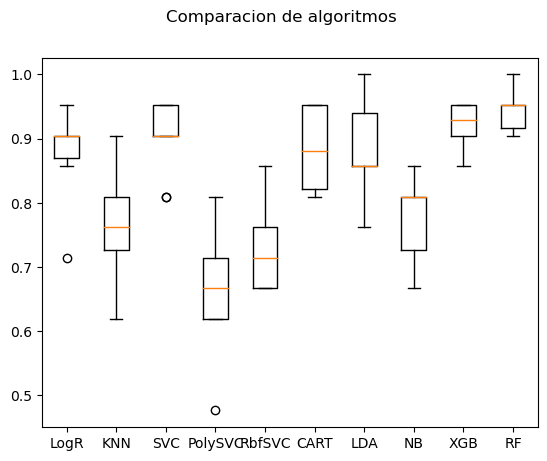

In [276]:
#Datos cercanos al 100% mejor, pero existen outlighter? q dan
fig = plt.figure()
fig.suptitle('Comparacion de algoritmos')
ax = fig.add_subplot(111)
# datos de cada fold de las 10 pruebas
plt.boxplot(scores)
ax.set_xticklabels(modelos)
plt.show()

In [278]:
#Se observan que los modelos con mejor metrica son XGB, RF, SVC y logR con valores bien distribuidos a una tendensia central.

## 1.6 Probando los modelos

### MAQUINAS DE SOPORTE VECTORIAL
La mejor métrica Accuracy y F1Score  fue del modelo con valores estandarizados con valores de metricas de:  

- Accuracy (Test): 97.86%
- F1-score (Test): 97.94

In [285]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

In [313]:
test_size = 0.2
X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size = test_size, random_state = seed)

model = xgb.XGBClassifier()
model.fit(X_train,Y_train)
results = model.score(X_train,Y_train)
predicted = model.predict(X_train)
matriz = confusion_matrix(Y_train,predicted)
print("="*60)
print("TRAINING\n")
print(f' Accuracy (Training): {results.mean()*100.0:,.2f}% ({results.std()*100.0:,.2f}%)')
print(matriz)
report=classification_report(Y_train,predicted)
print(report)

print("="*60)
print("Test\n")
predicted = model.predict(X_test)
matriz = confusion_matrix(Y_test,predicted)
print(matriz)
report=classification_report(Y_test,predicted)
print(report)
print(f' Accuracy (Test): {accuracy_score(Y_test,predicted)*100.0:,.2f}%')
f1 = f1_score(Y_test, predicted, average='macro')
print(f' F1-score (Test): {f1*100:,.2f}')

TRAINING

 Accuracy (Training): 100.00% (0.00%)
[[241   0   0   0   0   0   0]
 [  0 240   0   0   0   0   0]
 [  0   0 237   0   0   0   0]
 [  0   0   0 221   0   0   0]
 [  0   0   0   0 239   0   0]
 [  0   0   0   0   0 251   0]
 [  0   0   0   0   0   0 251]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       241
         1.0       1.00      1.00      1.00       240
         2.0       1.00      1.00      1.00       237
         3.0       1.00      1.00      1.00       221
         4.0       1.00      1.00      1.00       239
         5.0       1.00      1.00      1.00       251
         6.0       1.00      1.00      1.00       251

    accuracy                           1.00      1680
   macro avg       1.00      1.00      1.00      1680
weighted avg       1.00      1.00      1.00      1680

Test

[[59  0  0  0  0  0  0]
 [ 0 60  0  0  0  0  0]
 [ 0  0 59  0  4  0  0]
 [ 0  0  2 77  0  0  0]
 [ 0  0  3  1 56  0  1]
 [ 0  0  0 

In [314]:
test_size = 0.2
NX_train, NX_test, NY_train, NY_test = train_test_split(normalizedX,y, test_size = test_size, random_state = seed)

model = xgb.XGBClassifier()
model.fit(NX_train,NY_train)
results = model.score(NX_train,NY_train)
predicted = model.predict(NX_train)
matriz = confusion_matrix(NY_train,predicted)
print("="*60)
print("TRAINING\n")
print(f' Accuracy (Training): {results.mean()*100.0:,.2f}% ({results.std()*100.0:,.2f}%)')
print(matriz)
report=classification_report(NY_train,predicted)
print(report)

print("="*60)
print("Test\n")
predicted = model.predict(NX_test)
matriz = confusion_matrix(NY_test,predicted)
print(matriz)
report=classification_report(NY_test,predicted)
print(report)
print(f' Accuracy (Test): {accuracy_score(NY_test,predicted)*100.0:,.2f}%')
f1 = f1_score(Y_test, predicted, average='macro')
print(f' F1-score (Test): {f1*100:,.2f}')

TRAINING

 Accuracy (Training): 100.00% (0.00%)
[[241   0   0   0   0   0   0]
 [  0 240   0   0   0   0   0]
 [  0   0 237   0   0   0   0]
 [  0   0   0 221   0   0   0]
 [  0   0   0   0 239   0   0]
 [  0   0   0   0   0 251   0]
 [  0   0   0   0   0   0 251]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       241
         1.0       1.00      1.00      1.00       240
         2.0       1.00      1.00      1.00       237
         3.0       1.00      1.00      1.00       221
         4.0       1.00      1.00      1.00       239
         5.0       1.00      1.00      1.00       251
         6.0       1.00      1.00      1.00       251

    accuracy                           1.00      1680
   macro avg       1.00      1.00      1.00      1680
weighted avg       1.00      1.00      1.00      1680

Test

[[59  0  0  0  0  0  0]
 [ 0 60  0  0  0  0  0]
 [ 0  0 59  1  3  0  0]
 [ 0  1  3 73  1  0  1]
 [ 0  0  2  2 57  0  0]
 [ 0  0  0 

In [315]:
test_size = 0.2
StX_train, StX_test, StY_train, StY_test = train_test_split(standarizedX,y, test_size = test_size, random_state = seed)

model = xgb.XGBClassifier()
model.fit(StX_train,StY_train)
results = model.score(StX_train,NY_train)
predicted = model.predict(StX_train)
matriz = confusion_matrix(StY_train,predicted)
print("="*60)
print("TRAINING\n")
print(f' Accuracy (Training): {results.mean()*100.0:,.2f}% ({results.std()*100.0:,.2f}%)')
print(matriz)
report=classification_report(StY_train,predicted)
print(report)

print("="*60)
print("Test\n")
predicted = model.predict(StX_test)
matriz = confusion_matrix(StY_test,predicted)
print(matriz)
report=classification_report(StY_test,predicted)
print(report)
print(f' Accuracy (Test): {accuracy_score(StY_test,predicted)*100.0:,.2f}%')
f1 = f1_score(StY_test, predicted, average='macro')
print(f' F1-score (Test): {f1*100:,.2f}')

TRAINING

 Accuracy (Training): 100.00% (0.00%)
[[241   0   0   0   0   0   0]
 [  0 240   0   0   0   0   0]
 [  0   0 237   0   0   0   0]
 [  0   0   0 221   0   0   0]
 [  0   0   0   0 239   0   0]
 [  0   0   0   0   0 251   0]
 [  0   0   0   0   0   0 251]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       241
         1.0       1.00      1.00      1.00       240
         2.0       1.00      1.00      1.00       237
         3.0       1.00      1.00      1.00       221
         4.0       1.00      1.00      1.00       239
         5.0       1.00      1.00      1.00       251
         6.0       1.00      1.00      1.00       251

    accuracy                           1.00      1680
   macro avg       1.00      1.00      1.00      1680
weighted avg       1.00      1.00      1.00      1680

Test

[[59  0  0  0  0  0  0]
 [ 0 60  0  0  0  0  0]
 [ 0  0 59  0  4  0  0]
 [ 0  0  1 78  0  0  0]
 [ 0  0  2  1 57  0  1]
 [ 0  0  0 

In [316]:
test_size = 0.2
rsX_train, rsX_test, rsY_train, rsY_test = train_test_split(rescaledX,y, test_size = test_size, random_state = seed)

model = xgb.XGBClassifier()
model.fit(rsX_train,rsY_train)
results = model.score(rsX_train,rsY_train)
predicted = model.predict(rsX_train)
matriz = confusion_matrix(rsY_train,predicted)
print("="*60)
print("TRAINING\n")
print(f' Accuracy (Training): {results.mean()*100.0:,.2f}% ({results.std()*100.0:,.2f}%)')
print(matriz)
report=classification_report(StY_train,predicted)
print(report)

print("="*60)
print("Test\n")
predicted = model.predict(rsX_test)
matriz = confusion_matrix(rsY_test,predicted)
print(matriz)
report=classification_report(rsY_test,predicted)
print(report)
print(f' Accuracy (Test): {accuracy_score(rsY_test,predicted)*100.0:,.2f}%')
f1 = f1_score(rsY_test, predicted, average='macro')
print(f' F1-score (Test): {f1*100:,.2f}')


TRAINING

 Accuracy (Training): 100.00% (0.00%)
[[241   0   0   0   0   0   0]
 [  0 240   0   0   0   0   0]
 [  0   0 237   0   0   0   0]
 [  0   0   0 221   0   0   0]
 [  0   0   0   0 239   0   0]
 [  0   0   0   0   0 251   0]
 [  0   0   0   0   0   0 251]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       241
         1.0       1.00      1.00      1.00       240
         2.0       1.00      1.00      1.00       237
         3.0       1.00      1.00      1.00       221
         4.0       1.00      1.00      1.00       239
         5.0       1.00      1.00      1.00       251
         6.0       1.00      1.00      1.00       251

    accuracy                           1.00      1680
   macro avg       1.00      1.00      1.00      1680
weighted avg       1.00      1.00      1.00      1680

Test

[[59  0  0  0  0  0  0]
 [ 0 60  0  0  0  0  0]
 [ 0  0 59  0  4  0  0]
 [ 0  0  1 78  0  0  0]
 [ 0  0  3  2 56  0  0]
 [ 0  0  0 

## 1.7 Feature Selections

### 1.7.1 KForest

In [318]:
# Escogeremos solo 5 caracteristicas de las caracteristicas reescaladas entre 0 y 1 debido que para usar ch2
# los valores deben ser no negativos

In [342]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# Extracción de características
test = SelectKBest(score_func=chi2, k=18)
fit = test.fit(rescaledX, y)

# Scores
print(list(names[1:]))
print(fit.scores_)

# Características seleccionadas
features = fit.transform(rescaledX)
selected_indices = fit.get_support(indices=True)
selected_features = [names[i+1] for i in selected_indices]
print("Características seleccionadas:")
print(selected_features)
print(features[0:5, :])

['REGION-CENTROID-COL', 'REGION-CENTROID-ROW', 'REGION-PIXEL-COUNT', 'SHORT-LINE-DENSITY-5', 'SHORT-LINE-DENSITY-2', 'VEDGE-MEAN', 'VEDGE-SD', 'HEDGE-MEAN', 'HEDGE-SD', 'INTENSITY-MEAN', 'RAWRED-MEAN', 'RAWBLUE-MEAN', 'RAWGREEN-MEAN', 'EXRED-MEAN', 'EXBLUE-MEAN', 'EXGREEN-MEAN', 'VALUE-MEAN', 'SATURATION-MEAN', 'HUE-MEAN']
[ 35.427 197.962     nan  21.343  35.14   26.293  27.994  32.426  18.344
 528.419 522.75  546.639 522.989  94.426 192.129 160.268 518.912 143.042
 469.939]
Características seleccionadas:
['REGION-CENTROID-COL', 'REGION-CENTROID-ROW', 'SHORT-LINE-DENSITY-5', 'SHORT-LINE-DENSITY-2', 'VEDGE-MEAN', 'VEDGE-SD', 'HEDGE-MEAN', 'HEDGE-SD', 'INTENSITY-MEAN', 'RAWRED-MEAN', 'RAWBLUE-MEAN', 'RAWGREEN-MEAN', 'EXRED-MEAN', 'EXBLUE-MEAN', 'EXGREEN-MEAN', 'VALUE-MEAN', 'SATURATION-MEAN', 'HUE-MEAN']
[[4.308e-01 7.417e-01 0.000e+00 0.000e+00 3.422e-02 6.722e-04 2.733e-02
  8.557e-04 9.011e-02 7.942e-02 6.112e-02 1.309e-01 7.313e-01 1.412e-02
  8.729e-01 1.237e-01 5.081e-01 8.318e-01

In [343]:
test_size = 0.2
chi2X_train, chi2X_test, chi2Y_train, chi2Y_test = train_test_split(features,y, test_size = test_size, random_state = seed)
model = xgb.XGBClassifier()
model.fit(chi2X_train,chi2Y_train)
results = model.score(chi2X_train,rsY_train)
predicted = model.predict(chi2X_train)
matriz = confusion_matrix(chi2Y_train,predicted)
print("="*60)
print("TRAINING\n")
print(f' Accuracy (Training): {results.mean()*100.0:,.2f}% ({results.std()*100.0:,.2f}%)')
print(matriz)
report=classification_report(StY_train,predicted)
print(report)

print("="*60)
print("Test\n")
predicted = model.predict(chi2X_test)
matriz = confusion_matrix(chi2Y_test,predicted)
print(matriz)
report=classification_report(chi2Y_test,predicted)
print(report)
print(f' Accuracy (Test): {accuracy_score(chi2Y_test,predicted)*100.0:,.2f}%')
f1 = f1_score(chi2Y_test, predicted, average='macro')
print(f' F1-score (Test): {f1*100:,.2f}')

TRAINING

 Accuracy (Training): 100.00% (0.00%)
[[241   0   0   0   0   0   0]
 [  0 240   0   0   0   0   0]
 [  0   0 237   0   0   0   0]
 [  0   0   0 221   0   0   0]
 [  0   0   0   0 239   0   0]
 [  0   0   0   0   0 251   0]
 [  0   0   0   0   0   0 251]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       241
         1.0       1.00      1.00      1.00       240
         2.0       1.00      1.00      1.00       237
         3.0       1.00      1.00      1.00       221
         4.0       1.00      1.00      1.00       239
         5.0       1.00      1.00      1.00       251
         6.0       1.00      1.00      1.00       251

    accuracy                           1.00      1680
   macro avg       1.00      1.00      1.00      1680
weighted avg       1.00      1.00      1.00      1680

Test

[[59  0  0  0  0  0  0]
 [ 0 60  0  0  0  0  0]
 [ 0  0 59  0  4  0  0]
 [ 0  0  1 78  0  0  0]
 [ 0  0  3  2 56  0  0]
 [ 0  0  0 

In [344]:
# Con 18 caracteristicas en comparación de las 19 obtuvo el mismo resultadon reduciendo dos dimensiones al modelo.

In [ ]:
# La elección de caracteristicas mejoró 

### 1.7.2 Eliminacion recursiva de caracteristicas

In [345]:
from sklearn.feature_selection import RFE

model = xgb.XGBClassifier()
rfe = RFE (model,n_features_to_select=15)
fit=rfe.fit(standarizedX,y)

selected_features = fit.support_
selected_indices = [i for i, value in enumerate(selected_features) if value]
rfe_X = standarizedX[:, selected_indices]

print(list(df_train.columns[1:]))
print(f'Num features: {fit.n_features_} ')
print(f'Select features: {fit.support_} ')
print(f'Features Ranking: {fit.ranking_} ')

['REGION-CENTROID-COL', 'REGION-CENTROID-ROW', 'REGION-PIXEL-COUNT', 'SHORT-LINE-DENSITY-5', 'SHORT-LINE-DENSITY-2', 'VEDGE-MEAN', 'VEDGE-SD', 'HEDGE-MEAN', 'HEDGE-SD', 'INTENSITY-MEAN', 'RAWRED-MEAN', 'RAWBLUE-MEAN', 'RAWGREEN-MEAN', 'EXRED-MEAN', 'EXBLUE-MEAN', 'EXGREEN-MEAN', 'VALUE-MEAN', 'SATURATION-MEAN', 'HUE-MEAN']
Num features: 15 
Select features: [ True  True False  True False  True False  True  True  True  True  True
  True  True  True  True False  True  True] 
Features Ranking: [1 1 5 1 4 1 2 1 1 1 1 1 1 1 1 1 3 1 1] 


In [346]:
## Se seleccionaron 15 caracteristicas

In [348]:
test_size = 0.2
rfeX_train, rfeX_test, rfeY_train, rfeY_test = train_test_split(rfe_X,y, test_size = test_size, random_state = seed)
model = xgb.XGBClassifier()
model.fit(rfeX_train,rfeY_train)
results = model.score(rfeX_train,rfeY_train)
predicted = model.predict(rfeX_train)
matriz = confusion_matrix(rfeY_train,predicted)
print("="*60)
print("TRAINING\n")
print(f' Accuracy (Training): {results.mean()*100.0:,.2f}% ({results.std()*100.0:,.2f}%)')
print(matriz)
report=classification_report(rfeY_train,predicted)
print(report)
print("="*60)
print("Test\n")
predicted = model.predict(rfeX_test)
matriz = confusion_matrix(rfeY_test,predicted)
print(matriz)
report=classification_report(rfeY_test,predicted)
print(report)
print(f' Accuracy (Test): {accuracy_score(rfeY_test,predicted)*100.0:,.2f}%')
f1 = f1_score(rfeY_test, predicted, average='macro')
print(f' F1-score (Test): {f1*100:,.2f}')

TRAINING

 Accuracy (Training): 100.00% (0.00%)
[[241   0   0   0   0   0   0]
 [  0 240   0   0   0   0   0]
 [  0   0 237   0   0   0   0]
 [  0   0   0 221   0   0   0]
 [  0   0   0   0 239   0   0]
 [  0   0   0   0   0 251   0]
 [  0   0   0   0   0   0 251]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       241
         1.0       1.00      1.00      1.00       240
         2.0       1.00      1.00      1.00       237
         3.0       1.00      1.00      1.00       221
         4.0       1.00      1.00      1.00       239
         5.0       1.00      1.00      1.00       251
         6.0       1.00      1.00      1.00       251

    accuracy                           1.00      1680
   macro avg       1.00      1.00      1.00      1680
weighted avg       1.00      1.00      1.00      1680

Test

[[59  0  0  0  0  0  0]
 [ 0 60  0  0  0  0  0]
 [ 0  0 60  0  3  0  0]
 [ 0  0  1 78  0  0  0]
 [ 0  0  4  0 55  0  2]
 [ 0  0  0 

El modelo disminuyó en 5 caracteristicas pero sus metricas también disminuyeron:

- Accuracy (Test): 97.86%
- F1-score (Test): 97.94

Ahora:

- Accuracy (Test): 97.62%
- F1-score (Test): 97.65

### 1.7.3 PCA

In [361]:
#Como una transformacion de 4 a 2 atributos
from sklearn.decomposition import PCA

pca = PCA(n_components=15)
fit = pca.fit(standarizedX)
X_transform = pca.transform(standarizedX)

C=pca.components_
#Aumentar num componentes hasta q la suma salga 0.95+
#Entre menor num comp mejor?
print(f"Explained Variance: {fit.explained_variance_ratio_}")
print(f"Components: {C}")
df_pca = pd.DataFrame(data=X_transform,columns=[f'PC{i}' for i in range(0,15)])
print("La suma es",sum(fit.explained_variance_ratio_))
df_pca.head()

Explained Variance: [4.234e-01 1.606e-01 9.944e-02 5.822e-02 5.182e-02 5.085e-02 4.101e-02
 3.198e-02 3.057e-02 2.116e-02 1.437e-02 1.027e-02 6.218e-03 1.760e-05
 1.586e-16]
Components: [[ 2.476e-02 -1.996e-01  1.110e-16 -1.315e-02  4.190e-03  2.135e-02
   1.224e-02  2.716e-02  1.545e-02  3.513e-01  3.484e-01  3.574e-01
   3.430e-01 -3.118e-01  3.284e-01 -2.447e-01  3.545e-01 -2.126e-01
  -1.783e-01]
 [ 1.069e-03  2.609e-02 -4.250e-17 -3.514e-02  2.530e-01  4.680e-01
   4.804e-01  4.701e-01  4.968e-01 -4.019e-02 -4.572e-02 -3.079e-02
  -4.567e-02 -1.748e-02  2.944e-02 -3.240e-02 -3.420e-02  4.601e-03
  -7.919e-02]
 [ 1.456e-01  3.752e-01 -0.000e+00  1.145e-01 -3.895e-02  2.242e-02
   3.691e-02  8.783e-02  5.646e-02  1.346e-01  1.355e-01  8.904e-02
   1.869e-01 -1.013e-01 -1.924e-01  4.269e-01  1.222e-01 -3.634e-01
   5.957e-01]
 [-6.697e-01  3.461e-02  0.000e+00  7.307e-01  3.869e-02  3.276e-02
  -4.510e-02  6.321e-02 -1.301e-02  7.534e-03  1.164e-02  9.281e-03
   1.395e-03  3.111e-02 

PC0       PC1       PC2       PC3       PC4       PC5       PC6       PC7       PC8  \
0 -3.065538 -0.619007  2.270508 -0.274774 -0.968620  0.068254  0.677774 -0.069751 -0.223987   
1 -2.957565 -0.576610  2.274977 -0.035729 -1.180553  0.125848  0.545220 -0.069707 -0.088200   
2 -3.118842  0.100534  2.860224 -1.216227  0.283989  0.073598 -0.114089 -0.581909 -0.537175   
3 -3.243500 -0.573516  2.369381  0.337915 -1.501262  0.382618  0.236052 -0.349982 -0.371905   
4 -2.891930 -0.612673  2.326523 -0.135683 -1.087976  0.080673  0.567876 -0.053025  0.047338   

        PC9      PC10      PC11      PC12      PC13          PC14  
0 -0.102769 -0.041242  0.025303 -0.020963 -0.074620 -3.122054e-08  
1 -0.115274  0.042913 -0.006196 -0.017808 -0.063594  2.352371e-08  
2 -0.296551 -0.453744  0.232378 -0.134850 -0.036099 -3.297156e-08  
3  0.289807 -0.299052  0.138674  0.081892 -0.065844 -3.957851e-08  
4 -0.111211 -0.068508  0.058028  0.018049 -0.075551 -3.931271e-08

In [359]:
df_pca

PC0       PC1       PC2       PC3       PC4       PC5       PC6       PC7       PC8  \
0    -3.065538 -0.619007  2.270508 -0.274774 -0.968620  0.068254  0.677774 -0.069751 -0.223987   
1    -2.957565 -0.576610  2.274977 -0.035729 -1.180553  0.125848  0.545220 -0.069707 -0.088200   
2    -3.118842  0.100534  2.860224 -1.216227  0.283989  0.073598 -0.114089 -0.581909 -0.537175   
3    -3.243500 -0.573516  2.369381  0.337915 -1.501262  0.382618  0.236052 -0.349982 -0.371905   
4    -2.891930 -0.612673  2.326523 -0.135683 -1.087976  0.080673  0.567876 -0.053025  0.047338   
...        ...       ...       ...       ...       ...       ...       ...       ...       ...   
2095 -1.939786 -0.369204 -0.858516  0.515268 -0.936921  0.222303 -0.436460 -0.068969  0.046252   
2096 -1.971407 -0.408190 -0.484813  2.714945  0.469514 -0.372087 -0.056864 -0.208824  0.036095   
2097 -1.998508 -0.450277 -0.683671 -0.378072 -0.014727  0.052250 -0.327501  0.065438 -0.080605   
2098 -1.872852 -0.075825 -0.551204 -0.539273  0.205738 -0.052191 -0.481512 -0.205823  0.095947   
2099 -1.730142 -0.222319 -0.248230  1.688385  1.619686 -0.522114 -0.184822  0.093558 -0.188716   

           PC9      PC10      PC11      PC12      PC13          PC14  
0    -0.102769 -0.041242  0.025303 -0.020963 -0.074620 -3.122054e-08  
1    -0.115274  0.042913 -0.006196 -0.017808 -0.063594  2.352371e-08  
2    -0.296551 -0.453744  0.232378 -0.134850 -0.036099 -3.297157e-08  
3     0.289807 -0.299052  0.138674  0.081892 -0.065844 -3.957851e-08  
4    -0.111211 -0.068508  0.058028  0.018049 -0.075551 -3.931272e-08  
...        ...       ...       ...       ...       ...           ...  
2095  0.518421 -0.106233  0.035809  0.437894  0.003040 -2.204315e-09  
2096  0.473789 -0.172672  0.169691  0.713218  0.006778  1.198531e-08  
2097  0.506531 -0.202625  0.016615  0.412785  0.002163 -1.844603e-08  
2098  0.161894 -0.250237  0.161676  0.346457  0.002965 -2.272809e-08  
2099  0.243270 -0.221325 -0.023587  0.529561  0.004705 -2.866968e-08  

[2100 rows x 15 columns]

In [360]:
test_size = 0.2
pcaX_train, pcaX_test, pcaY_train, pcaY_test = train_test_split(X_transform,y, test_size = test_size, random_state = seed)
model = xgb.XGBClassifier()
model.fit(pcaX_train,pcaY_train)
results = model.score(pcaX_train,pcaY_train)
predicted = model.predict(pcaX_train)
matriz = confusion_matrix(pcaY_train,predicted)
print("="*60)
print("TRAINING\n")
print(f' Accuracy (Training): {results.mean()*100.0:,.2f}% ({results.std()*100.0:,.2f}%)')
print(matriz)
report=classification_report(pcaY_train,predicted)
print(report)
print("="*60)
print("Test\n")
predicted = model.predict(pcaX_test)
matriz = confusion_matrix(pcaY_test,predicted)
print(matriz)
report=classification_report(pcaY_test,predicted)
print(report)
print(f' Accuracy (Test): {accuracy_score(pcaY_test,predicted)*100.0:,.2f}%')
f1 = f1_score(pcaY_test, predicted, average='macro')
print(f' F1-score (Test): {f1*100:,.2f}')

TRAINING

 Accuracy (Training): 100.00% (0.00%)
[[241   0   0   0   0   0   0]
 [  0 240   0   0   0   0   0]
 [  0   0 237   0   0   0   0]
 [  0   0   0 221   0   0   0]
 [  0   0   0   0 239   0   0]
 [  0   0   0   0   0 251   0]
 [  0   0   0   0   0   0 251]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       241
         1.0       1.00      1.00      1.00       240
         2.0       1.00      1.00      1.00       237
         3.0       1.00      1.00      1.00       221
         4.0       1.00      1.00      1.00       239
         5.0       1.00      1.00      1.00       251
         6.0       1.00      1.00      1.00       251

    accuracy                           1.00      1680
   macro avg       1.00      1.00      1.00      1680
weighted avg       1.00      1.00      1.00      1680

Test

[[59  0  0  0  0  0  0]
 [ 0 58  0  2  0  0  0]
 [ 0  0 55  2  6  0  0]
 [ 0  1  5 73  0  0  0]
 [ 0  0  4  2 55  0  0]
 [ 0  0  0 

Se escoguieron 15 caracteristicas con PCA pero se obtuvo menores valores de métricas:
- Accuracy (Test): 94.52%
- F1-score (Test): 94.99

## 1.8 Pipeline

In [365]:
from sklearn.pipeline import Pipeline

estimadores=[]
estimadores.append(('Standarize',StandardScaler()))  #fit, transform
estimadores.append(('LDA',xgb.XGBClassifier()))  #fit, predict, score
model= Pipeline(estimadores)
#Evaluar
kfold=KFold(n_splits=10,random_state=seed,shuffle=True)
results=cross_val_score(model,X,y,cv=kfold)
print(f' Accuracy: {results.mean()*100.0:,.2f}% ({results.std()*100.0:,.2f}%)')


 Accuracy: 98.19% (0.90%)


In [366]:
# Ahora probaremso con datos no vistos
array_test = data_test.values  #solo valores
#Separar el input del target
X=array_test[:,1:]
y=array_test[:,0]

In [ ]:
## Con datos no visto de data_test se optuvo 93% de accuaracy

In [377]:
from sklearn.pipeline import Pipeline

estimadores=[]
estimadores.append(('Standarize',StandardScaler()))  #fit, transform
estimadores.append(('XGB',xgb.XGBClassifier()))  #fit, predict, score
model= Pipeline(estimadores)
#Evaluar
kfold=KFold(n_splits=5,random_state=seed,shuffle=True)
results=cross_val_score(model,X,y,cv=kfold)
print(f' Accuracy: {results.mean()*100.0:,.2f}% ({results.std()*100.0:,.2f}%)')

 Accuracy: 93.81% (3.23%)


## Conclusiones


Se concluye que el mejor modelo de segmentación es XGB con valores de test:

- Accuracy (Test): 97.86%
- F1-score (Test): 97.94

Y valor de Accuracy:

- 93.81% (3.23%)

Los valores  de las clases estuvieron distribuidos uniformemente.
Si reducimos la dimensión a 15 características con RFE tenemos:

- Accuracy (Test): 97.62%
- F1-score (Test): 97.65